# Imports and Data loading

In [879]:
######### List of imports ################
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
import pmdarima as pm
from ThymeBoost import ThymeBoost as tb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
# import plotly.offline as py
from sklearn.linear_model import LinearRegression
import ta

###########################################

######### Models to consider ############
# 1. GBRT
# 2. LSTM - Recurrent NN (both feedforward and feedback)
# 3. LightGBM - Efficient GBRT with feature building
# 4. Elastic Net
# 5. ARIMA
#######################################

In [611]:
## Read data from "BTCUSD"

data1 = pd.read_csv("/Users/yuhaoli/code/HowardLiYH/Volatility-prediction/datasets/raw/raw_data.csv")

In [606]:
data1.head()

,scrape_time,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02
0,2023-03-27 10:30:36,17668615506,27905.28,12.59899,27904.92,0.01921,27905.29,1.58571,27905.30,1.02708
1,2023-03-27 10:30:41,17668615812,27905.28,13.05932,27905.15,0.00208,27905.29,3.29816,27905.30,0.00252
2,2023-03-27 10:30:45,17668616793,27909.14,10.13004,27909.03,0.09094,27909.15,5.28372,27909.94,0.09800
3,2023-03-27 10:30:50,17668617069,27909.14,9.63960,27909.03,0.09094,27909.15,5.83321,27909.16,0.00401
4,2023-03-27 10:30:54,17668617292,27909.14,0.22453,27908.60,0.00559,27909.15,6.31910,27909.16,0.00401


# Feature Creation

In [607]:
# Weighted Average Price 
data['WAP'] = (data['bids_price_01']*data['bids_size_01']
               +data['bids_price_02']*data['bids_size_02']
               +data['ask_price_01']*data['ask_size_01']
               +data['ask_price_02']*data['ask_size_02'])/(data['bids_size_01']+
                                         data['bids_size_02']+
                                         data['ask_size_01']+
                                         data['ask_size_02'])

KeyError: 'bids_price_01'

In [608]:
## Spread
data['spread'] = ((data['ask_price_01']/data['bids_price_01']) - 1)

KeyError: 'ask_price_01'

In [609]:
## Log price

def log_price(list_stock_prices):
    return np.log(list_stock_prices)

data.insert(0, 'log_price', log_price(data['WAP']))

data['log_returns'] = data.log_price.diff()

ValueError: cannot insert log_price, already exists

In [29]:
## Realized Volatility
def realized_volatility():
    list_vol = []
    i = 0
    for i in data.index:
        x = np.std(data.log_returns.iloc[:i])
        i += 1
        list_vol.append(x)
    
    return list_vol

data['realized_volatility'] = realized_volatility()

In [30]:
## Previous volatility

data['volatility_t+1'] = data['realized_volatility'].shift(-1)

In [38]:
y = data['realized_volatility'].to_frame()

In [40]:
## Create a copy of data named df
df = data

In [42]:
## Drop the target y
df.drop(['realized_volatility'], axis = 1, inplace = True) 

In [45]:
## Check if two roles have the same value
df.duplicated().value_counts()

False    7263
dtype: int64

In [47]:
df

,log_price,scrape_time,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1
0,10.236571,2023-03-27 10:30:36,17668615506,27905.28,12.59899,27904.92,0.01921,27905.29,1.58571,27905.30,1.02708,27905.281936,3.583551e-07,NaN,NaN
1,10.236571,2023-03-27 10:30:41,17668615812,27905.28,13.05932,27905.15,0.00208,27905.29,3.29816,27905.30,0.00252,27905.282002,3.583551e-07,2.385111e-09,0.000000
2,10.236710,2023-03-27 10:30:45,17668616793,27909.14,10.13004,27909.03,0.09094,27909.15,5.28372,27909.94,0.09800,27909.147770,3.583056e-07,1.385222e-04,0.000069
3,10.236710,2023-03-27 10:30:50,17668617069,27909.14,9.63960,27909.03,0.09094,27909.15,5.83321,27909.16,0.00401,27909.143110,3.583056e-07,-1.669880e-07,0.000065
4,10.236710,2023-03-27 10:30:54,17668617292,27909.14,0.22453,27908.60,0.00559,27909.15,6.31910,27909.16,0.00401,27909.149194,3.583056e-07,2.180208e-07,0.000060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7258,10.206226,2023-03-27 19:54:46,17675595465,27071.21,3.93922,27071.20,0.00232,27071.22,3.04686,27071.26,0.70701,27071.218550,3.693961e-07,1.207422e-07,0.000274
7259,10.206227,2023-03-27 19:54:51,17675595763,27071.21,1.05540,27071.20,0.00232,27071.22,5.07080,27071.32,0.69941,27071.228691,3.693961e-07,3.745986e-07,0.000274
7260,10.206071,2023-03-27 19:54:56,17675596986,27067.00,0.40343,27066.84,0.38190,27067.01,7.31261,27067.05,0.30726,27067.003258,3.694536e-07,-1.560979e-04,0.000274
7261,10.205793,2023-03-27 19:55:00,17675598589,27059.43,1.50309,27058.51,0.09800,27059.44,4.31640,27060.11,0.55458,27059.481007,3.695569e-07,-2.779509e-04,0.000274


# Deal with Missing Data

In [48]:
imputer = SimpleImputer(strategy="constant", fill_value = 0) # Instantiate a SimpleImputer object with your strategy of choice

imputer.fit(df[['volatility_t+1']]) # Call the "fit" method on the object

df['volatility_t+1'] = imputer.transform(df[['volatility_t+1']]) # Call the "transform" method on the object

imputer.statistics_ # The mean is stored in the transformer's memory

array([0.])

In [55]:
imputer2 = SimpleImputer(strategy="constant", fill_value = df.iloc[1,13])

imputer2.fit(df[['log_returns']]) # Call the "fit" method on the object

df['log_returns'] = imputer2.transform(df[['log_returns']]) # Call the "transform" method on the object

imputer2.statistics_ # The mean is stored in the transformer's memory

array([2.38511078e-09])

In [58]:
df.head()

,log_price,scrape_time,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1
0,10.236571,2023-03-27 10:30:36,17668615506,27905.28,12.59899,27904.92,0.01921,27905.29,1.58571,27905.30,1.02708,27905.281936,3.583551e-07,2.385111e-09,0.000000
1,10.236571,2023-03-27 10:30:41,17668615812,27905.28,13.05932,27905.15,0.00208,27905.29,3.29816,27905.30,0.00252,27905.282002,3.583551e-07,2.385111e-09,0.000000
2,10.236710,2023-03-27 10:30:45,17668616793,27909.14,10.13004,27909.03,0.09094,27909.15,5.28372,27909.94,0.09800,27909.147770,3.583056e-07,1.385222e-04,0.000069
3,10.236710,2023-03-27 10:30:50,17668617069,27909.14,9.63960,27909.03,0.09094,27909.15,5.83321,27909.16,0.00401,27909.143110,3.583056e-07,-1.669880e-07,0.000065
4,10.236710,2023-03-27 10:30:54,17668617292,27909.14,0.22453,27908.60,0.00559,27909.15,6.31910,27909.16,0.00401,27909.149194,3.583056e-07,2.180208e-07,0.000060


In [61]:
df.columns

Index(['log_price', 'scrape_time', 'lastUpdateId', 'bids_price_01',
       'bids_size_01', 'bids_price_02', 'bids_size_02', 'ask_price_01',
       'ask_size_01', 'ask_price_02', 'ask_size_02', 'WAP', 'spread',
       'log_returns', 'volatility_t+1'],
      dtype='object')

In [63]:
## bid depth, ask depth, Order Flow Imbalance (OFI) can not be executed properly due to size limitation

In [65]:
#sum of all bid quantities
df['bid depth'] = data[["bids_size_01", "bids_size_02"]].sum(axis=1)

#sum of all ask quantities
df['ask depth'] = data[["ask_size_01", "ask_size_02"]].sum(axis=1)

In [67]:
#Order Flow Imbalance (OFI) 
#relative quantities of bids vs asks
#full depth (approx 20 levels) OFI
df['FDOFI'] = (df['bid depth']-df['ask depth'])/(df['bid depth']+df['ask depth'])

In [69]:
df = df.set_index('scrape_time')

In [352]:
df.head()

,log_price,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1,bid depth,ask depth,FDOFI,realized_volatility
scrape_time,,,,,,,,,,,,,,,,,,
2023-03-27 10:30:36,0.927579,0.000000,0.925868,0.309343,0.925703,0.002270,0.925721,0.104673,0.925721,0.051879,0.925789,0.000004,0.514758,0.000000,0.309788,0.106035,0.828490,0.000000
2023-03-27 10:30:41,0.927579,0.000044,0.925868,0.320645,0.925862,0.000245,0.925721,0.217712,0.925721,0.000127,0.925789,0.000004,0.514758,0.000000,0.320670,0.133956,0.798303,0.000000
2023-03-27 10:30:45,0.930197,0.000184,0.928539,0.248722,0.928547,0.010752,0.928397,0.348780,0.928938,0.004950,0.928466,0.000004,0.537461,0.219483,0.250933,0.218423,0.655094,0.000000
2023-03-27 10:30:50,0.930194,0.000224,0.928539,0.236681,0.928547,0.010752,0.928397,0.385052,0.928397,0.000202,0.928463,0.000004,0.514730,0.207057,0.238891,0.236911,0.625058,0.000069
2023-03-27 10:30:54,0.930198,0.000256,0.928539,0.005513,0.928249,0.000660,0.928397,0.417126,0.928397,0.000202,0.928467,0.000004,0.514793,0.190057,0.005640,0.256633,0.035071,0.000065


In [128]:
imputer3 = SimpleImputer(strategy="constant", fill_value = 0) # Instantiate a SimpleImputer object with your strategy of choice

imputer3.fit(y[['realized_volatility']]) # Call the "fit" method on the object

y['realized_volatility'] = imputer3.transform(y[['realized_volatility']]) # Call the "transform" method on the object

imputer3.statistics_ # The mean is stored in the transformer's memory

array([0.])

In [129]:
y

,realized_volatility
0,0.000000
1,0.000000
2,0.000000
3,0.000069
4,0.000065
...,...
7258,0.000274
7259,0.000274
7260,0.000274
7261,0.000274


In [ ]:
imputer = SimpleImputer(strategy="constant", fill_value = 0) # Instantiate a SimpleImputer object with your strategy of choice

imputer.fit(df[['volatility_t+1']]) # Call the "fit" method on the object

df['volatility_t+1'] = imputer.transform(df[['volatility_t+1']]) # Call the "transform" method on the object

imputer.statistics_ # The mean is stored in the transformer's memory

# Plotting to visualize the features

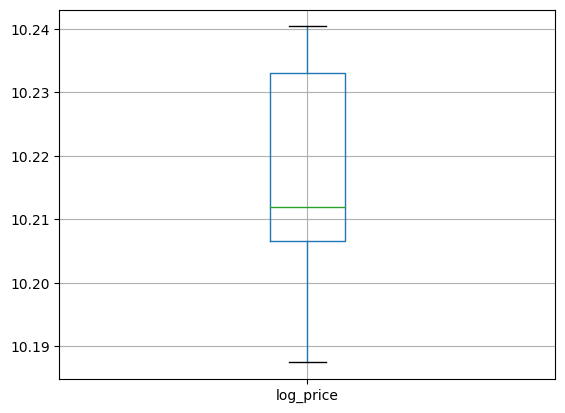

In [81]:
data[['log_price']].boxplot();
plt.show()

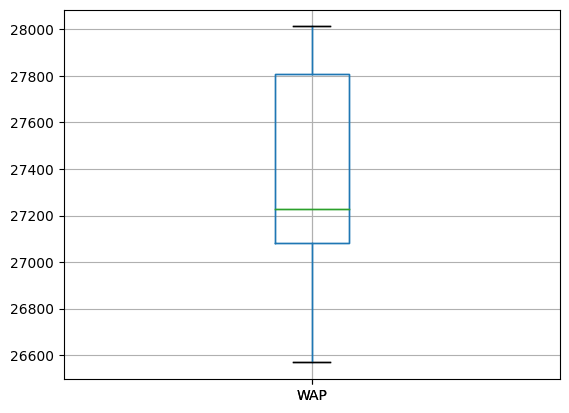

In [83]:
data[['WAP']].boxplot();
plt.show()

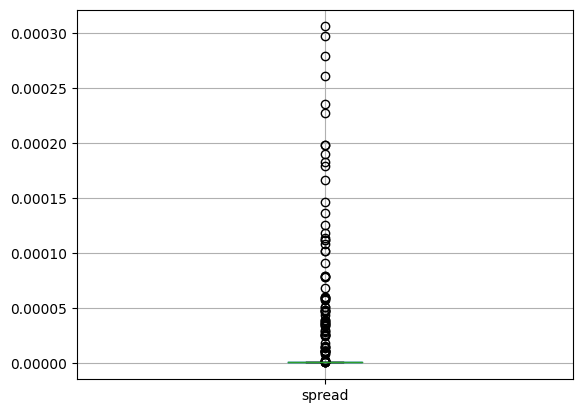

In [84]:
data[['spread']].boxplot();
plt.show()

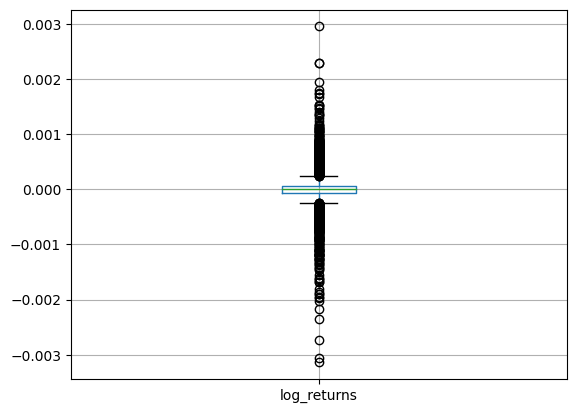

In [89]:
data[['log_returns']].boxplot();
plt.show()

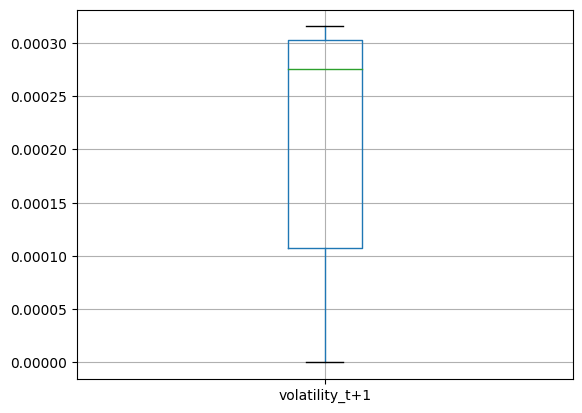

In [90]:
data[['volatility_t+1']].boxplot();
plt.show()

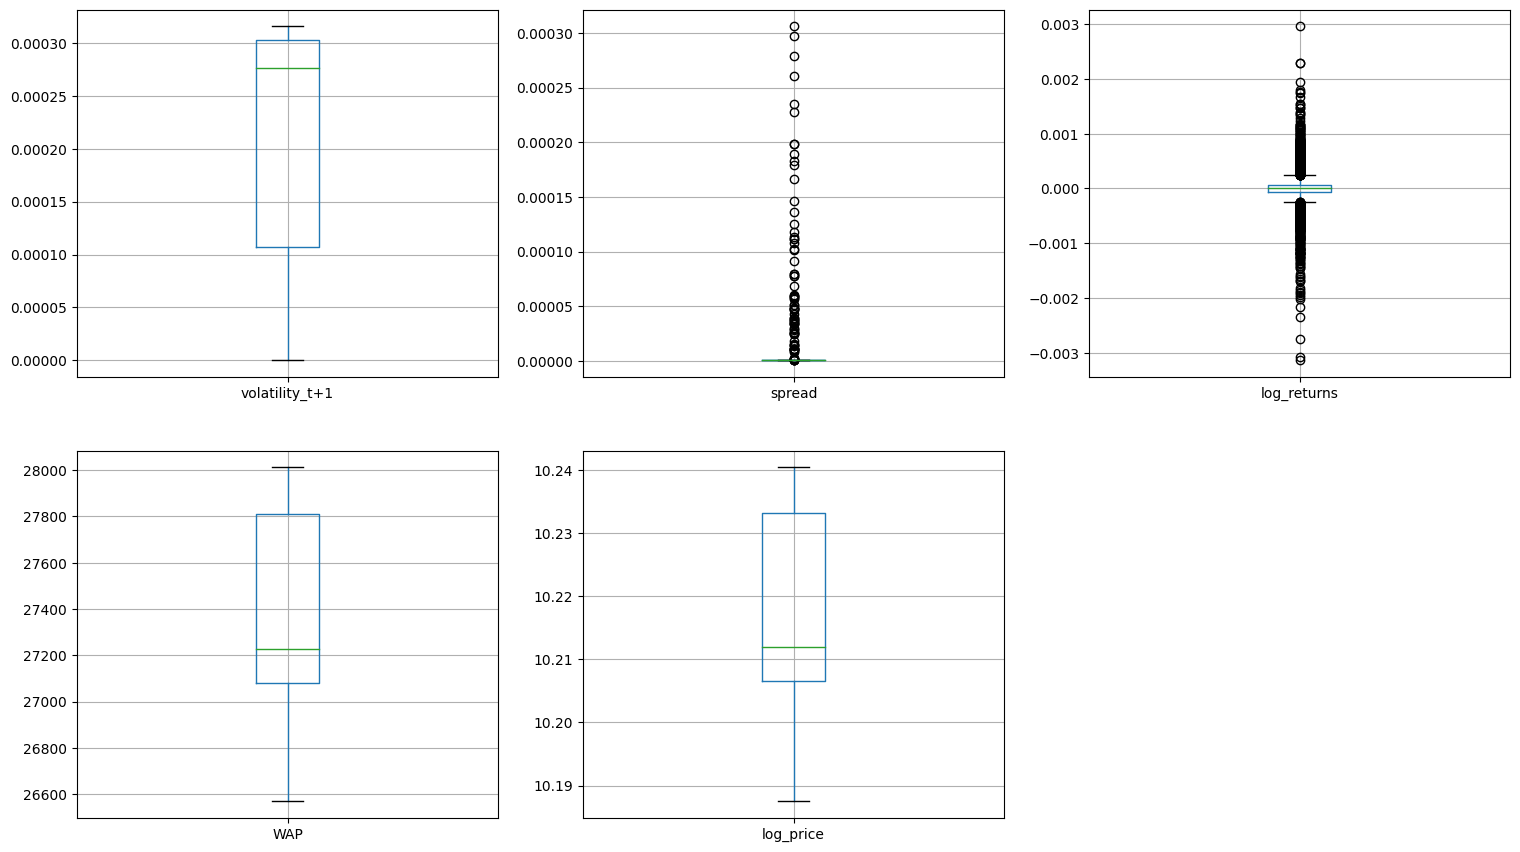

In [107]:
## All in one 
plt.subplot(2, 3, 1)
data[['volatility_t+1']].boxplot()

plt.subplot(2, 3, 2)
data[['spread']].boxplot()

plt.subplot(2, 3, 3)
data[['log_returns']].boxplot()

plt.subplot(2, 3, 4)
data[['WAP']].boxplot()

plt.subplot(2, 3, 5)
data[['log_price']].boxplot()

# x = np.array([0, 1, 2, 3])
# y = np.array([10, 20, 30, 40])

# plt.subplot(2, 3, 6)
# plt.plot(x,y)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# figure(figsize=(150, 150), dpi=300)

plt.show()

# Scaling Data

In [108]:
df.head()

,log_price,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1,bid depth,ask depth,FDOFI
scrape_time,,,,,,,,,,,,,,,,,
2023-03-27 10:30:36,10.236571,17668615506,27905.28,12.59899,27904.92,0.01921,27905.29,1.58571,27905.30,1.02708,27905.281936,3.583551e-07,2.385111e-09,0.000000,12.61820,2.61279,0.656911
2023-03-27 10:30:41,10.236571,17668615812,27905.28,13.05932,27905.15,0.00208,27905.29,3.29816,27905.30,0.00252,27905.282002,3.583551e-07,2.385111e-09,0.000000,13.06140,3.30068,0.596545
2023-03-27 10:30:45,10.236710,17668616793,27909.14,10.13004,27909.03,0.09094,27909.15,5.28372,27909.94,0.09800,27909.147770,3.583056e-07,1.385222e-04,0.000069,10.22098,5.38172,0.310155
2023-03-27 10:30:50,10.236710,17668617069,27909.14,9.63960,27909.03,0.09094,27909.15,5.83321,27909.16,0.00401,27909.143110,3.583056e-07,-1.669880e-07,0.000065,9.73054,5.83722,0.250089
2023-03-27 10:30:54,10.236710,17668617292,27909.14,0.22453,27908.60,0.00559,27909.15,6.31910,27909.16,0.00401,27909.149194,3.583056e-07,2.180208e-07,0.000060,0.23012,6.32311,-0.929769


In [113]:
# MinMaxScaler (Normalizing): each feature will be in a fixed range in [0,1] & preserve matrix sparsity

scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)
df

,log_price,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1,bid depth,ask depth,FDOFI
scrape_time,,,,,,,,,,,,,,,,,
2023-03-27 10:30:36,0.927579,0.000000,0.925868,0.309343,0.925703,0.002270,0.925721,0.104673,0.925721,0.051879,0.925789,0.000004,0.514758,0.000000,0.309788,0.106035,0.828490
2023-03-27 10:30:41,0.927579,0.000044,0.925868,0.320645,0.925862,0.000245,0.925721,0.217712,0.925721,0.000127,0.925789,0.000004,0.514758,0.000000,0.320670,0.133956,0.798303
2023-03-27 10:30:45,0.930197,0.000184,0.928539,0.248722,0.928547,0.010752,0.928397,0.348780,0.928938,0.004950,0.928466,0.000004,0.537461,0.219483,0.250933,0.218423,0.655094
2023-03-27 10:30:50,0.930194,0.000224,0.928539,0.236681,0.928547,0.010752,0.928397,0.385052,0.928397,0.000202,0.928463,0.000004,0.514730,0.207057,0.238891,0.236911,0.625058
2023-03-27 10:30:54,0.930198,0.000256,0.928539,0.005513,0.928249,0.000660,0.928397,0.417126,0.928397,0.000202,0.928467,0.000004,0.514793,0.190057,0.005640,0.256633,0.035071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27 19:54:46,0.354159,0.999455,0.348817,0.096719,0.348846,0.000273,0.347526,0.201124,0.347547,0.035712,0.348123,0.000041,0.514777,0.869490,0.096762,0.152350,0.512196
2023-03-27 19:54:51,0.354166,0.999498,0.348817,0.025913,0.348846,0.000273,0.347526,0.334725,0.347588,0.035328,0.348130,0.000041,0.514819,0.869430,0.025959,0.234191,0.154878
2023-03-27 19:54:56,0.351217,0.999673,0.345904,0.009905,0.345829,0.045158,0.344607,0.482708,0.344628,0.015520,0.345204,0.000041,0.489173,0.869389,0.019272,0.309267,0.093395


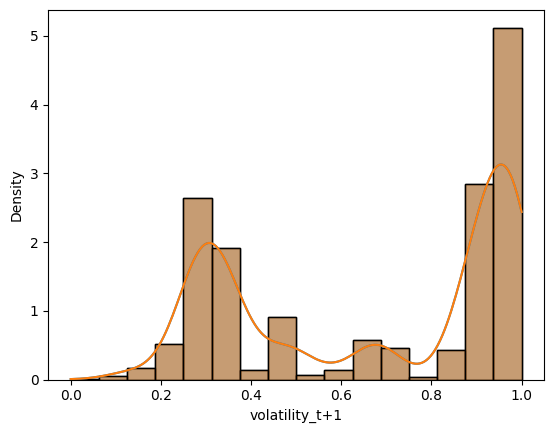

In [117]:
sns.histplot(df['volatility_t+1'], kde = True, stat='density');
plt.show()

Temporary Classification

- Above 0.75 -> high
- Between 0.65 & 0.75 -> medium
- Less than 0.65 -> low

In [119]:
df.head()

,log_price,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1,bid depth,ask depth,FDOFI
scrape_time,,,,,,,,,,,,,,,,,
2023-03-27 10:30:36,0.927579,0.000000,0.925868,0.309343,0.925703,0.002270,0.925721,0.104673,0.925721,0.051879,0.925789,0.000004,0.514758,0.000000,0.309788,0.106035,0.828490
2023-03-27 10:30:41,0.927579,0.000044,0.925868,0.320645,0.925862,0.000245,0.925721,0.217712,0.925721,0.000127,0.925789,0.000004,0.514758,0.000000,0.320670,0.133956,0.798303
2023-03-27 10:30:45,0.930197,0.000184,0.928539,0.248722,0.928547,0.010752,0.928397,0.348780,0.928938,0.004950,0.928466,0.000004,0.537461,0.219483,0.250933,0.218423,0.655094
2023-03-27 10:30:50,0.930194,0.000224,0.928539,0.236681,0.928547,0.010752,0.928397,0.385052,0.928397,0.000202,0.928463,0.000004,0.514730,0.207057,0.238891,0.236911,0.625058
2023-03-27 10:30:54,0.930198,0.000256,0.928539,0.005513,0.928249,0.000660,0.928397,0.417126,0.928397,0.000202,0.928467,0.000004,0.514793,0.190057,0.005640,0.256633,0.035071


In [155]:
y = y.set_index(data['scrape_time'])

In [164]:
df['realized_volatility'] = y['realized_volatility']

In [165]:
df

,log_price,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1,bid depth,ask depth,FDOFI,realized_volatility
scrape_time,,,,,,,,,,,,,,,,,,
2023-03-27 10:30:36,0.927579,0.000000,0.925868,0.309343,0.925703,0.002270,0.925721,0.104673,0.925721,0.051879,0.925789,0.000004,0.514758,0.000000,0.309788,0.106035,0.828490,0.000000
2023-03-27 10:30:41,0.927579,0.000044,0.925868,0.320645,0.925862,0.000245,0.925721,0.217712,0.925721,0.000127,0.925789,0.000004,0.514758,0.000000,0.320670,0.133956,0.798303,0.000000
2023-03-27 10:30:45,0.930197,0.000184,0.928539,0.248722,0.928547,0.010752,0.928397,0.348780,0.928938,0.004950,0.928466,0.000004,0.537461,0.219483,0.250933,0.218423,0.655094,0.000000
2023-03-27 10:30:50,0.930194,0.000224,0.928539,0.236681,0.928547,0.010752,0.928397,0.385052,0.928397,0.000202,0.928463,0.000004,0.514730,0.207057,0.238891,0.236911,0.625058,0.000069
2023-03-27 10:30:54,0.930198,0.000256,0.928539,0.005513,0.928249,0.000660,0.928397,0.417126,0.928397,0.000202,0.928467,0.000004,0.514793,0.190057,0.005640,0.256633,0.035071,0.000065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27 19:54:46,0.354159,0.999455,0.348817,0.096719,0.348846,0.000273,0.347526,0.201124,0.347547,0.035712,0.348123,0.000041,0.514777,0.869490,0.096762,0.152350,0.512196,0.000274
2023-03-27 19:54:51,0.354166,0.999498,0.348817,0.025913,0.348846,0.000273,0.347526,0.334725,0.347588,0.035328,0.348130,0.000041,0.514819,0.869430,0.025959,0.234191,0.154878,0.000274
2023-03-27 19:54:56,0.351217,0.999673,0.345904,0.009905,0.345829,0.045158,0.344607,0.482708,0.344628,0.015520,0.345204,0.000041,0.489173,0.869389,0.019272,0.309267,0.093395,0.000274


In [167]:
# df['volatility_levels'] = pd.cut(x = df['realized_volatility'],
#                        bins=[df['realized_volatility'].min()-1,
#                              np.percentile(df['realized_volatility'], 25),
#                              np.percentile(df['realized_volatility'], 50),
#                              np.percentile(df['realized_volatility'],75),
#                              df['realized_volatility'].max()+1], 
#                        labels=['low', 'medium','high'])

In [170]:
np.percentile(df['volatility_t+1'], 25), np.percentile(df['volatility_t+1'], 50), np.percentile(df['volatility_t+1'],75),

(0.34060535493594907, 0.8740633965930373, 0.9595653044630515)

Temporary Classification 

- Above 0.75 -> high
- Between 0.65 & 0.75 -> medium
- Less than 0.65 -> low

# Models

Let Baseline be predicting the previous value.

List of methods to try:
- ARIMA Time Series ✅ 
- RNN
- LSTM

## Baseline Model  ✅

In [198]:
df_vol= df['volatility_t+1'].to_frame()

In [200]:
# Let's keep the last 40% of the values out for testing purposes
train_size = 0.6
index = round(train_size*df_vol.shape[0])

df_train = df_vol.iloc[:index]
df_test = df_vol.iloc[index:]

In [201]:
y_pred = df_test.shift(1)
y_pred

,volatility_t+1
scrape_time,
2023-03-27 16:12:18,NaN
2023-03-27 16:12:23,0.996080
2023-03-27 16:12:27,0.995972
2023-03-27 16:12:33,0.995858
2023-03-27 16:12:38,0.995939
...,...
2023-03-27 19:54:46,0.869550
2023-03-27 19:54:51,0.869490
2023-03-27 19:54:56,0.869430


In [202]:
y_pred = df_test.shift(1).dropna()
y_true = df_test[1:]

print(f"R2: {r2_score(y_true, y_pred)}")

R2: 0.8615538391630807


## Linear Regression on Time Series  ✅

In [204]:
df2 = df.copy(); df2_train = df_train.copy(); df2_test = df_test.copy()

for i in range(1, 13):
    df2_train[f't - {i}'] = df_train['volatility_t+1'].shift(i)
    df2_test[f't - {i}'] = df_test['volatility_t+1'].shift(i)

df2_train.dropna(inplace=True)
df2_test.dropna(inplace=True)

df2_train.head()

,volatility_t+1,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12
scrape_time,,,,,,,,,,,,,
2023-03-27 10:31:33,0.176383,0.182780,0.189849,0.141815,0.149614,0.158785,0.169856,0.183520,0.190057,0.207057,0.219483,0.000000,0.000000
2023-03-27 10:31:38,0.170514,0.176383,0.182780,0.189849,0.141815,0.149614,0.158785,0.169856,0.183520,0.190057,0.207057,0.219483,0.000000
2023-03-27 10:31:42,0.165146,0.170514,0.176383,0.182780,0.189849,0.141815,0.149614,0.158785,0.169856,0.183520,0.190057,0.207057,0.219483
2023-03-27 10:31:47,0.160307,0.165146,0.170514,0.176383,0.182780,0.189849,0.141815,0.149614,0.158785,0.169856,0.183520,0.190057,0.207057
2023-03-27 10:31:51,0.155851,0.160307,0.165146,0.170514,0.176383,0.182780,0.189849,0.141815,0.149614,0.158785,0.169856,0.183520,0.190057


In [206]:
# Train Test Split
X2_train = df2_train.drop(columns = ['volatility_t+1'])
y2_train = df2_train['volatility_t+1']
X2_test = df2_test.drop(columns = ['volatility_t+1'])
y2_test = df2_test['volatility_t+1']

print(X2_train.shape,y2_train.shape, X2_test.shape,y2_test.shape)

(4346, 12) (4346,) (2893, 12) (2893,)


In [209]:
# Predict and measure R2
model = LinearRegression()
model = model.fit(X2_train, y2_train)

print('R2: ', r2_score(y2_test, model.predict(X2_test)))
pd.Series(model.coef_).plot(kind='bar')
plt.title('partial regression coefficients');

R2:  0.8606333122223265


## ARIMA Time Series ✅

FYI
What is ARIMA: https://medium.com/@pavanmeduri1_55193/time-series-forecasting-arima-model-d1e0c38770c0

👉 Example: ARIMA models recursively predict the next data points one after the other

### ARIMA data processing 

We don't need to additive decomposition nor multiplicative decomposition here since each volatility is not accumulative.

In [305]:
y_arima = df_vol.reset_index()["volatility_t+1"][2:-1]

In [306]:
##### Ensure stationarity ########
from statsmodels.tsa.stattools import adfuller

adfuller(y_arima)[1]  # p-value

0.14835862802530692

ADF tests the following precedure:

- The p-value should be less than 0.05 to have a 95% confidence in the stationarity.

- If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").



Steps:

1. Convert a non-stationary TS to stationary

2. Forecast stationary TS by extrapolating stationary properties

3. Reintroduce seasonality and the rest

In [307]:
differenced_1 = y_arima.diff().dropna()
differenced_2 = differenced_1.diff().dropna()

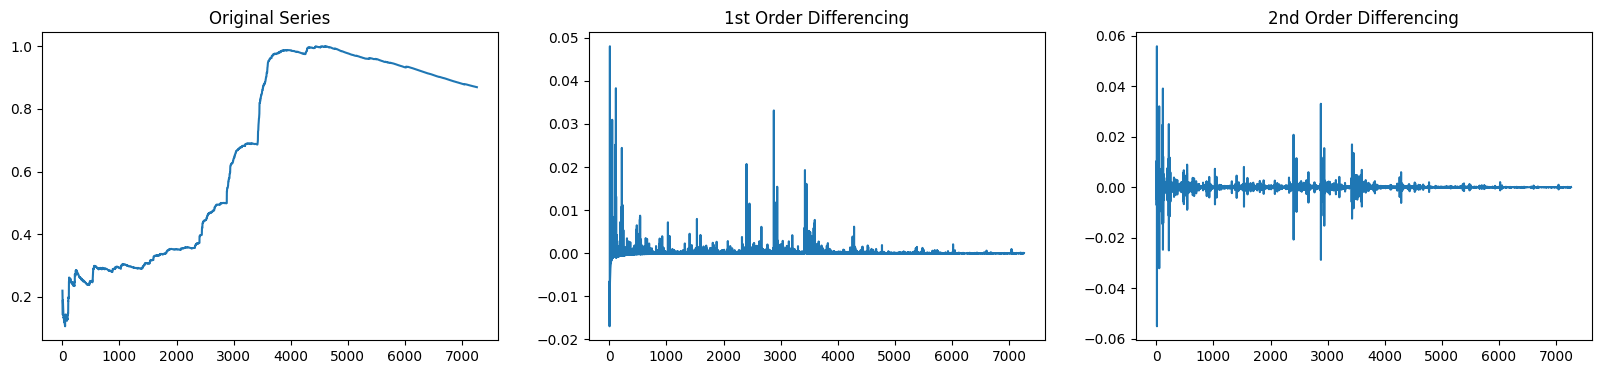

In [308]:
zero_diff = y_arima
first_order_diff = differenced_1
second_order_diff = differenced_2


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing');
plt.show()

### Auto-ARIMA (mape:0.1)

#### Autocorrelation(q) and Partial Autocorrelation(p)

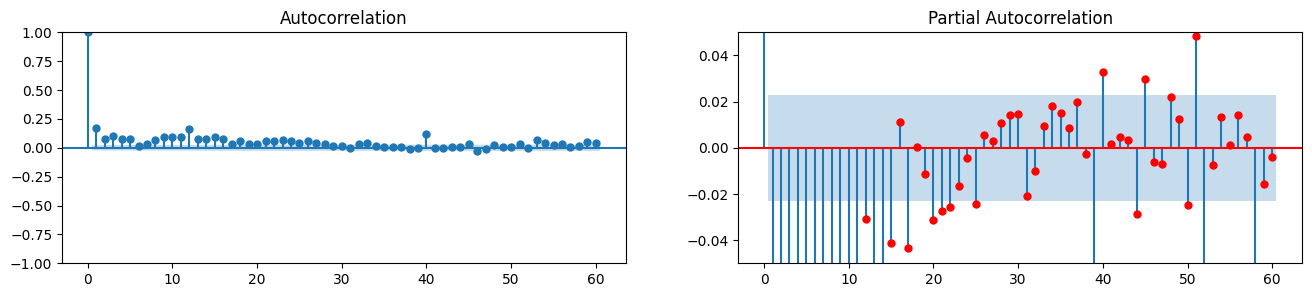

In [315]:
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(differenced_1, lags=60, ax=axes[0])

plot_pacf(differenced_2, lags=60, ax=axes[1], color='r');
plt.ylim(-0.05, 0.05)
plt.show()

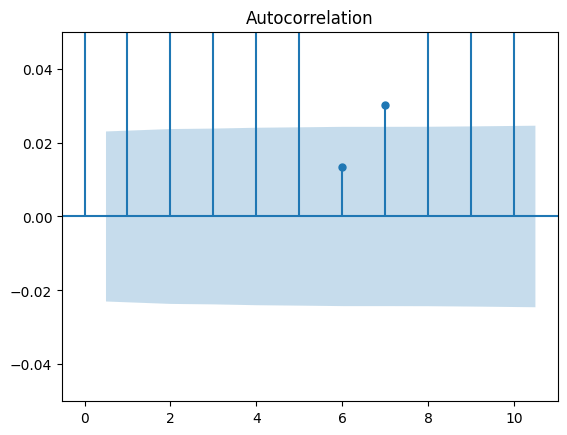

In [327]:
plot_acf(differenced_1, lags=10);
plt.ylim(-0.05, 0.05)
plt.show()
# q = 5

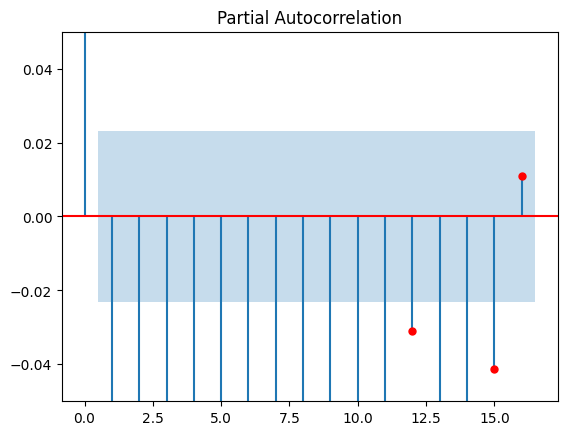

In [324]:
plot_pacf(differenced_2, lags=16, color='r');
plt.ylim(-0.05, 0.05)
plt.show()

# p = 14

In [336]:
## p,d,q
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(y_arima, order=(5, 1, 10), trend='t')
arima = arima.fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         volatility_t+1   No. Observations:                 7260
Model:                ARIMA(5, 1, 10)   Log Likelihood               37669.850
Date:                Tue, 28 Mar 2023   AIC                         -75305.700
Time:                        18:42:38   BIC                         -75188.570
Sample:                             0   HQIC                        -75265.413
                               - 7260                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          8.387e-05   4.74e-05      1.771      0.077   -8.97e-06       0.000
ar.L1          0.2221      0.005     48.917      0.000       0.213       0.231
ar.L2          0.2383      0.006     39.408      0.000       0.226       0.250
ar.L3          0.4916      0.006     85.870      0.000       0.480       0.503
ar.L4          0.0217      0.005      4.308      0.000       0.012       0.032
ar.L5         -0.1522      0.007    -22.517      0.000      -0.165      -0.139
ma.L1         -0.0630      0.005    -12.935      0.000      -0.073      -0.053
ma.L2         -0.2401      0.007    -35.920      0.000      -0.253      -0.227
ma.L3         -0.4551      0.007    -63.806      0.000      -0.469      -0.441
ma.L4         -0.0484      0.007     -6.595      0.000      -0.063      -0.034
ma.L5          0.1551      0.009     17.303      0.000       0.138       0.173
ma.L6         -0.0288      0.007     -4.068      0.000      -0.043      -0.015
ma.L7         -0.0242      0.007     -3.695      0.000      -0.037      -0.011
ma.L8         -0.0254      0.010     -2.623      0.009      -0.044      -0.006
ma.L9          0.0328      0.006      5.138      0.000       0.020       0.045
ma.L10         0.0416      0.006      6.968      0.000       0.030       0.053
sigma2      1.807e-06   4.54e-09    398.091      0.000     1.8e-06    1.82e-06
===================================================================================
Ljung-Box (L1) (Q):                   4.31   Jarque-Bera (JB):          80770711.01
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            17.65
Prob(H) (two-sided):                  0.00   Kurtosis:                       518.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.12e+17. Standard errors may be unstable.
"""

#### Forcasting plots (Evaluate model performance)

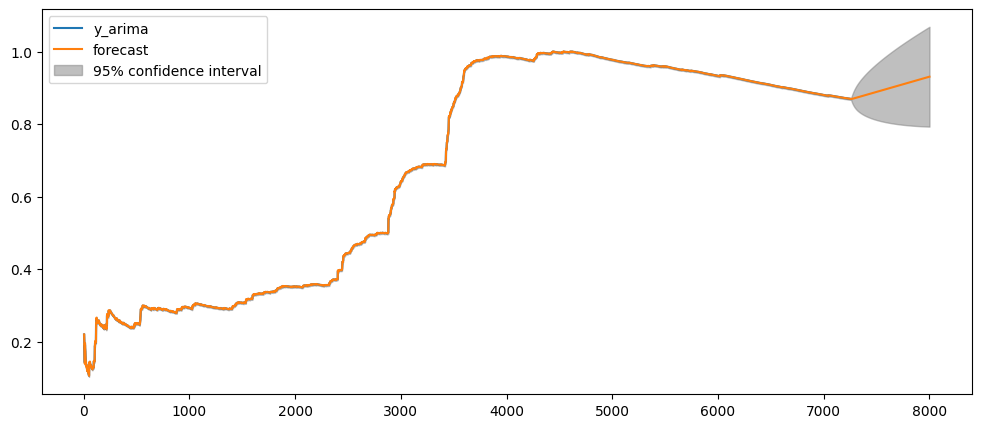

In [340]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(y_arima, label='y_arima');
plot_predict(arima, start=1, end=8000, ax=axs);

plt.show()

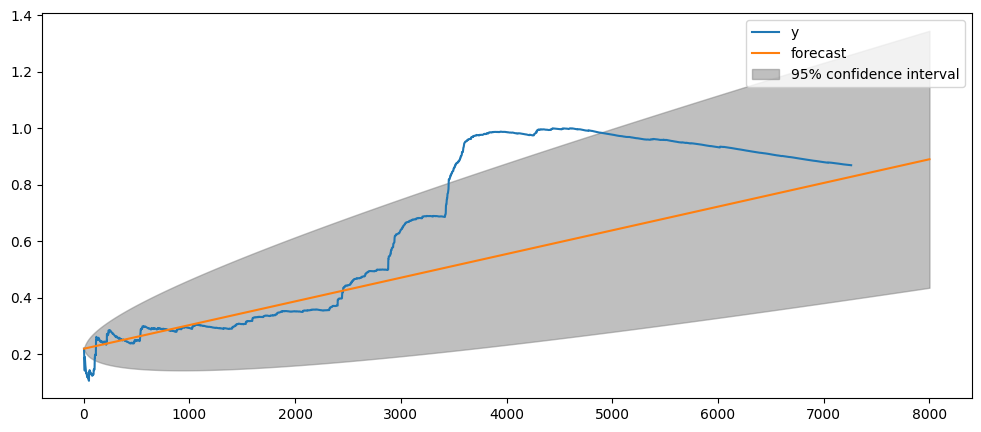

In [343]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(y_arima, label='y')
plot_predict(arima, start=1, end=8000, ax=axs, dynamic=True);
plt.show()

#### Out-of-Sample Forecasts (real "future")

In [347]:
y_arima = y_arima.reset_index()

In [349]:
y = y_arima['volatility_t+1']

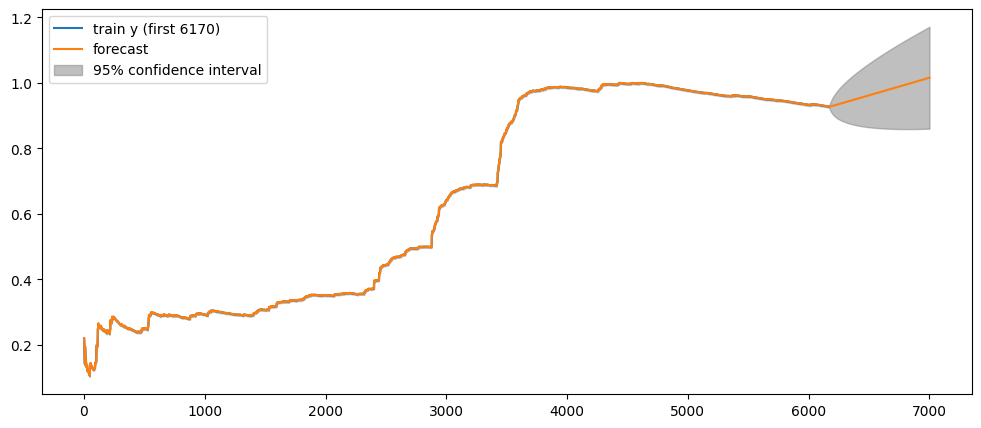

In [374]:
train = y[0:6170]
test = y[6170:]

arima2 = ARIMA(train, order=(5, 1, 10), trend='t')
arima2 = arima2.fit()

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train, label='train y (first 6170)')
plot_predict(arima2, start=1, end=7000, ax=axs, dynamic=False);
plt.show()

In [375]:
forecast_results = arima2.get_forecast(len(test), alpha=0.05)

## Here are the forcasts
forecast_train = forecast_results.predicted_mean

## Here are the confidence intervals
confidence_int = forecast_results.conf_int().values

In [376]:
# We define here a "Plot forecast vs. real", which also shows historical training set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

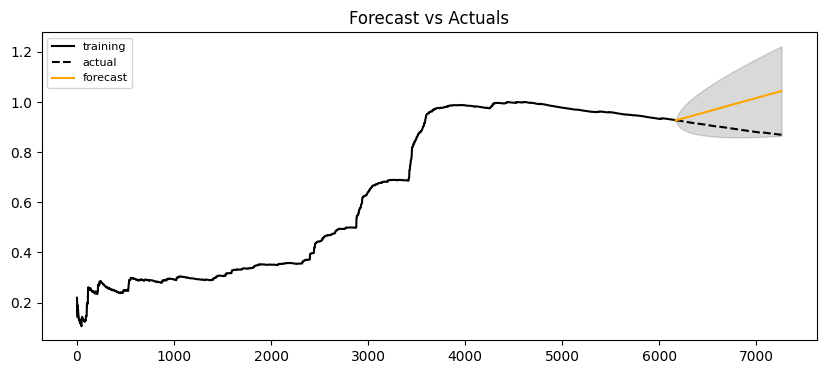

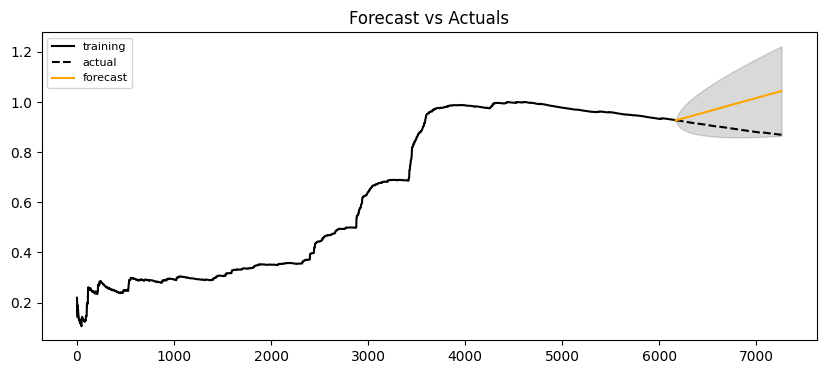

In [378]:
plot_forecast(forecast_train, train, test, confidence_int[:,0], confidence_int[:,1])
plt.show()

#### Condition for inference

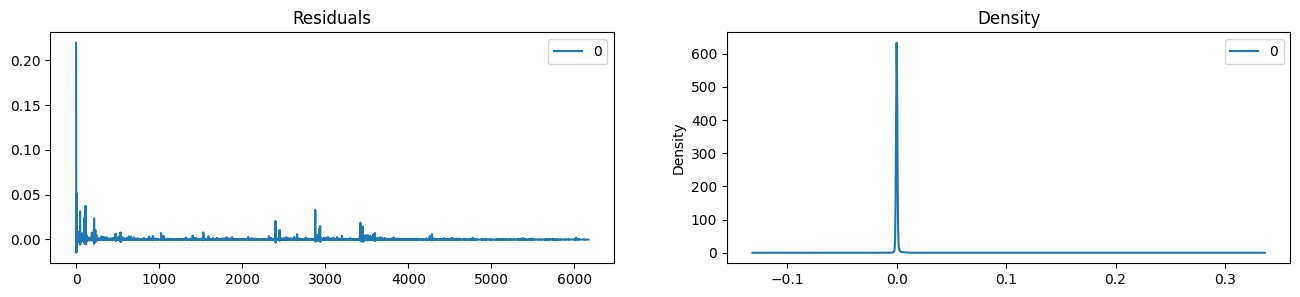

In [379]:
residuals = pd.DataFrame(arima2.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);
plt.show()

#### Cross-validation perfromance matrics

In [382]:
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast

In [383]:
forecast_accuracy(forecast_train, test)

{'mape': 0.09992800978516414,
 'me': 0.08861209421815305,
 'mae': 0.08861209421815305,
 'mpe': 0.09992800978516414,
 'rmse': 0.102087480133344,
 'acf1': 0.9972836417074067,
 'corr': -0.9987079501490795,
 'minmax': 0.0882766644398264}

#### Grid Search for further improvements

In [388]:
model = pm.auto_arima(
    train, 
    start_p=0, max_p=3,
    start_q=0, max_q=3, 
    d=None,           # let model determine 'd'
    test='adf',       # using adf test to find optimal 'd'
    trace=True, error_action='ignore',  suppress_warnings=True
)

print(model.summary())
## optimal is (0,2,3)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62659.075, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62835.645, Time=0.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-62816.826, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62625.393, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62847.441, Time=1.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62888.482, Time=1.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-62883.497, Time=0.88 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-62840.424, Time=1.32 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-62872.245, Time=0.53 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 7.079 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6170
Model:               SARIMAX(3, 1, 0)   Log Likelihood               31449.241
Date:                Tue, 28 Ma

The best model suggested here is ARMIA (3,1,0) (0,0,0) [0] intercept

#### Attempt with the suggested params

The best model suggested here is ARMIA (3,1,0) (0,0,0) [0] intercept

/opt/homebrew/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


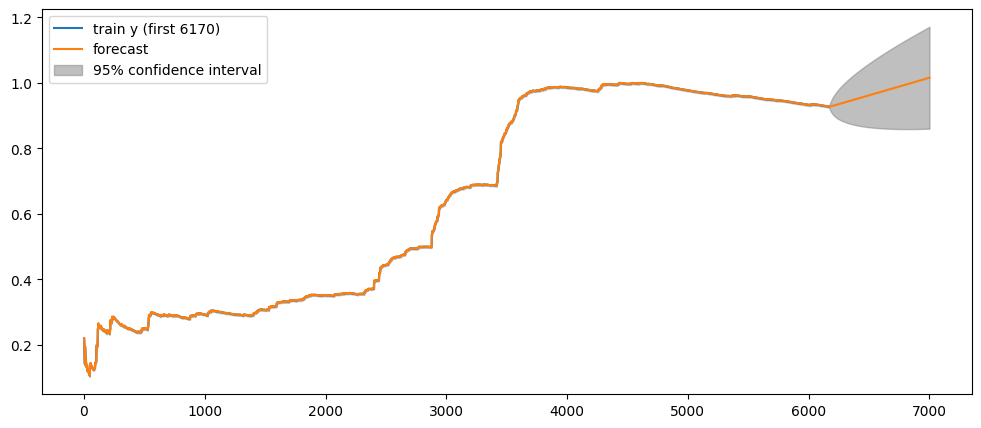

In [396]:
train = y[0:6170]
test = y[6170:]

arima3 = ARIMA(train, order=(3, 1, 0), trend='t')
arima3 = arima3.fit()

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train, label='train y (first 6170)')
plot_predict(arima2, start=1, end=7000, ax=axs, dynamic=False);
plt.show()

In [397]:
forecast_results = arima3.get_forecast(len(test), alpha=0.05)

## Here are the forcasts
forecast_train = forecast_results.predicted_mean

## Here are the confidence intervals
confidence_int = forecast_results.conf_int().values

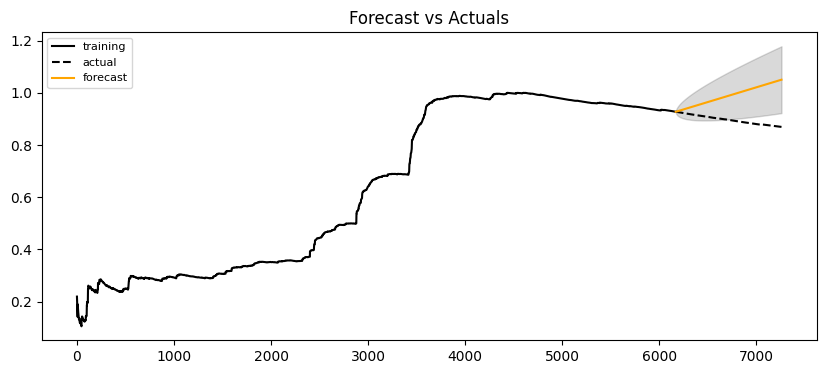

In [398]:
plot_forecast(forecast_train, train, test, confidence_int[:,0], confidence_int[:,1])
plt.show()

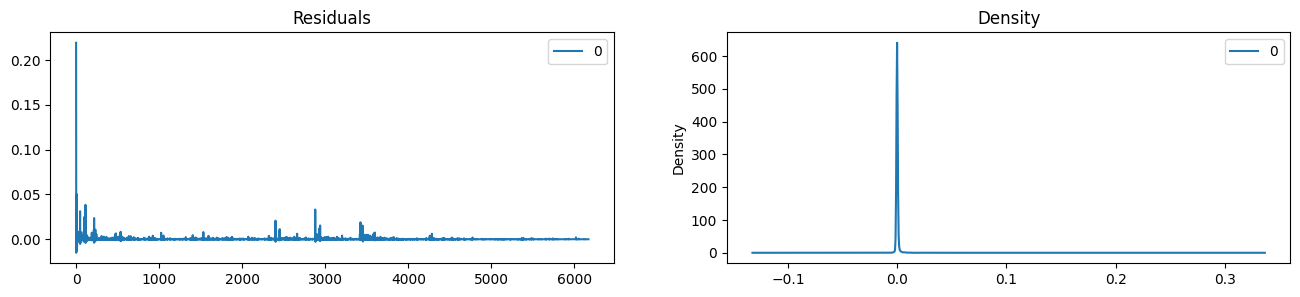

In [399]:
residuals = pd.DataFrame(arima3.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);
plt.show()

In [400]:
forecast_accuracy(forecast_train, test)

{'mape': 0.10393559272635704,
 'me': 0.09217272798828029,
 'mae': 0.09217272798828029,
 'mpe': 0.10393559272635704,
 'rmse': 0.10600693084028967,
 'acf1': 0.9972635973200906,
 'corr': -0.9987247987392772,
 'minmax': 0.09143280605237325}

### Boosted-Linear Auto-ARIMA (mape:0.047) 

Source: https://towardsdatascience.com/gradient-boosted-arima-for-time-series-forecasting-e093f80772f6

ThymeBoost: https://github.com/tblume1992/ThymeBoost

In [490]:
boosted_model = tb.ThymeBoost(verbose=1)
output = boosted_model.fit(train,
                            trend_estimator=['linear', 'arima'],
                            arima_order='auto',
                            global_cost='mse')
predicted_output = boosted_model.predict(output, len(test))
tb_mae = np.mean(np.abs(test - predicted_output['predictions']))
tb_rmse = (np.mean((test - predicted_output['predictions'])**2))**.5
tb_mape = np.sum(np.abs(predicted_output['predictions'] - test)) / (np.sum((np.abs(test))))

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 0.09694846538052182
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 0.01240948787199412
********** Round 3 **********
Using Split: None
Fitting global with trend model:
arima(auto)
seasonal model:
None
cost: 3.6970097191897893e-06
Boosting Terminated 
Using round 3


In [520]:
boosted_model2 = tb.ThymeBoost(verbose=0,
                           split_strategy='gradient')
output2 = boosted_model2.fit(train,
                           min_sample_pct=.2,
                           trend_estimator=['linear'],
                           additive = False,
                            seasonal_estimator='fourier',
                           seasonal_period=2500,
                           global_cost='maicc',
                           fit_type=['global', 'local'],
                           )
predicted_output2 = boosted_model2.predict(output2, len(test))

In [ ]:
boosted_mode3 = tb.ThymeBoost(verbose=1)
output = boosted_model.fit(train,
                            trend_estimator=['smoother'],
                            arima_order='auto',
                            global_cost='mse')
predicted_output = boosted_model.predict(output, len(test))
tb_mae = np.mean(np.abs(test - predicted_output['predictions']))
tb_rmse = (np.mean((test - predicted_output['predictions'])**2))**.5
tb_mape = np.sum(np.abs(predicted_output['predictions'] - test)) / (np.sum((np.abs(test))))

In [ ]:
tb_mape, tb_mae, tb_rmse, 

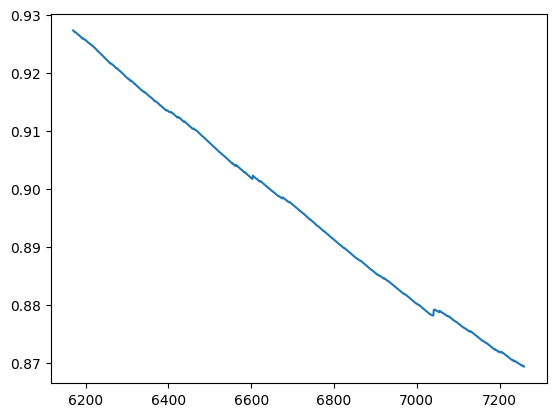

In [500]:
plt.plot(test)
plt.show()

In [406]:
tb_mape, tb_mae, tb_rmse, 

(0.004742652647796939, 0.004252360467151375, 0.005463235452542654)

In [509]:
# import sklearn.metrics as metrics
# def regression_results(y_true, y_pred):
#     # Regression metrics
#     explained_variance=metrics.explained_variance_score(y_true, y_pred)
#     mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
#     mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
#     median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
#     r2=metrics.r2_score(y_true, y_pred)
#     print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
#     print('r2: ', round(r2,4))
#     print('MAE: ', round(mean_absolute_error,4))
#     print('MSE: ', round(mse,4))
#     print('RMSE: ', round(np.sqrt(mse),4))

In [508]:
# regression_results(test, predicted_output['predictions'])

In [511]:
tb2_mae = np.mean(np.abs(test - predicted_output2['predictions']))
tb2_rmse = (np.mean((test - predicted_output2['predictions'])**2))**.5
tb2_mape = np.sum(np.abs(predicted_output2['predictions'] - test)) / (np.sum((np.abs(test))))

tb2_mape, tb2_mae, tb2_rmse, 

(0.06501758412746872, 0.05829611083615127, 0.06845419445042684)

## Gradient Boosting Random Forest 🚫

## Time series prediction with LSTM in Tensorflow (On Hold)

# Test for overfitting using time split validation

Might not be worth it: https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1

In [423]:
train = y[0:6170]
test = y[6170:]

In [424]:
len(train), len(test)

(6170, 1090)

In [452]:
# # Spot Check Algorithms
# models = []
# models.append(('BARIMA', tb.ThymeBoost(verbose=1)))

# # Evaluate each model in turn
# results = []
# names = []
# for name, model in models:
#     # TimeSeries Cross validation
#     tscv = TimeSeriesSplit(n_splits=len(train))
    
#     cv_results = cross_val_score(model, train,test, cv=tscv, scoring='r2')
#     results.append(cv_results)
#     names.append(name)
#     print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# # Compare Algorithms
# plt.boxplot(results, labels=names)
# plt.title('Algorithm Comparison')
# plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve

train_sizes = [25,50,75,100,250,500,750,1000,1150]
# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=boosted_model(), X=train, y=test, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
#plt.plot(train_sizes, train_scores_mean, label = 'Training score')
#plt.plot(train_sizes, test_scores_mean, label = 'Test score')
#plt.ylabel('r2 score', fontsize = 14)
#plt.xlabel('Training set size', fontsize = 14)
#plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.legend()

In [453]:
# X_train = data_consumption[:'2016'].drop(['Consumption'], axis = 1)
# y_train = data_consumption.loc[:'2016', 'Consumption']
# X_test = data_consumption['2017'].drop(['Consumption'], axis = 1)
# y_test = data_consumption.loc['2017', 'Consumption']

In [454]:
# # Spot Check Algorithms
# models = []
# models.append(('LR', LinearRegression()))
# models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
# models.append(('KNN', KNeighborsRegressor())) 
# models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
# models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# # Evaluate each model in turn
# results = []
# names = []
# for name, model in models:
#     # TimeSeries Cross validation
#     tscv = TimeSeriesSplit(n_splits=10)
    
#     cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
#     results.append(cv_results)
#     names.append(name)
#     print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# # Compare Algorithms
# plt.boxplot(results, labels=names)
# plt.title('Algorithm Comparison')
# plt.show()

# Random Trials

In [536]:
data

,log_price,scrape_time,lastUpdateId,bids_price_01,bids_size_01,bids_price_02,bids_size_02,ask_price_01,ask_size_01,ask_price_02,ask_size_02,WAP,spread,log_returns,volatility_t+1,bid depth,ask depth,FDOFI
0,10.236571,2023-03-27 10:30:36,17668615506,27905.28,12.59899,27904.92,0.01921,27905.29,1.58571,27905.30,1.02708,27905.281936,3.583551e-07,2.385111e-09,0.000000,12.61820,2.61279,0.656911
1,10.236571,2023-03-27 10:30:41,17668615812,27905.28,13.05932,27905.15,0.00208,27905.29,3.29816,27905.30,0.00252,27905.282002,3.583551e-07,2.385111e-09,0.000000,13.06140,3.30068,0.596545
2,10.236710,2023-03-27 10:30:45,17668616793,27909.14,10.13004,27909.03,0.09094,27909.15,5.28372,27909.94,0.09800,27909.147770,3.583056e-07,1.385222e-04,0.000069,10.22098,5.38172,0.310155
3,10.236710,2023-03-27 10:30:50,17668617069,27909.14,9.63960,27909.03,0.09094,27909.15,5.83321,27909.16,0.00401,27909.143110,3.583056e-07,-1.669880e-07,0.000065,9.73054,5.83722,0.250089
4,10.236710,2023-03-27 10:30:54,17668617292,27909.14,0.22453,27908.60,0.00559,27909.15,6.31910,27909.16,0.00401,27909.149194,3.583056e-07,2.180208e-07,0.000060,0.23012,6.32311,-0.929769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7258,10.206226,2023-03-27 19:54:46,17675595465,27071.21,3.93922,27071.20,0.00232,27071.22,3.04686,27071.26,0.70701,27071.218550,3.693961e-07,1.207422e-07,0.000274,3.94154,3.75387,0.024387
7259,10.206227,2023-03-27 19:54:51,17675595763,27071.21,1.05540,27071.20,0.00232,27071.22,5.07080,27071.32,0.69941,27071.228691,3.693961e-07,3.745986e-07,0.000274,1.05772,5.77021,-0.690178
7260,10.206071,2023-03-27 19:54:56,17675596986,27067.00,0.40343,27066.84,0.38190,27067.01,7.31261,27067.05,0.30726,27067.003258,3.694536e-07,-1.560979e-04,0.000274,0.78533,7.61987,-0.813132
7261,10.205793,2023-03-27 19:55:00,17675598589,27059.43,1.50309,27058.51,0.09800,27059.44,4.31640,27060.11,0.55458,27059.481007,3.695569e-07,-2.779509e-04,0.000274,1.60109,4.87098,-0.505231


# Model Testing with LSTM

In [457]:
data = pd.read_csv("/Users/yuhaoli/code/HowardLiYH/Volatility-prediction/datasets/raw/data_0401(6hrs).csv")

In [458]:
data.isnull().values.any()

False

In [459]:
data1 = pd.read_csv('/Users/yuhaoli/code/HowardLiYH/Volatility-prediction/datasets/raw/data0329.csv')

In [460]:
columns_name = list(data1.columns)[:-2]

In [461]:
data = data.iloc[:,2:]

In [462]:
data.columns = columns_name

In [463]:
data

,bp_1,bz_1,bp_2,bz_2,bp_3,bz_3,bp_4,bz_4,bp_5,bz_5,...,ap_16,az_16,ap_17,az_17,ap_18,az_18,ap_19,az_19,ap_20,az_20
0,28492.26,0.00037,28492.00,0.00176,28491.11,0.00377,28491.00,0.00176,28490.75,0.19738,...,28496.44,0.78696,28496.45,0.47363,28496.46,0.82804,28496.74,0.01817,28496.96,0.01999
1,28492.00,0.02180,28491.93,0.08660,28491.11,0.00377,28491.00,0.00176,28490.67,0.02518,...,28495.26,0.02287,28496.42,0.03038,28496.43,0.53314,28496.44,0.78696,28496.45,0.47363
2,28490.55,0.70889,28490.54,0.91462,28490.00,0.00275,28489.85,0.06192,28489.84,0.10000,...,28495.17,0.05167,28495.22,0.08000,28495.23,0.05019,28495.26,0.02287,28496.42,0.03038
3,28490.00,1.89468,28489.97,0.60454,28489.84,0.10000,28489.83,0.24396,28489.65,0.00312,...,28495.12,0.01137,28495.17,0.05167,28495.22,0.08000,28495.23,0.05019,28495.26,0.02287
4,28490.00,1.77856,28489.84,0.10000,28489.83,0.24396,28489.65,0.00312,28489.31,0.03686,...,28495.00,0.02451,28495.01,0.02935,28495.12,0.01137,28495.17,0.05167,28495.22,0.08000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9168,28395.00,1.38557,28394.94,0.53725,28394.92,2.25094,28394.76,0.92475,28394.33,0.00081,...,28398.36,0.04990,28398.81,0.01092,28399.00,0.00039,28399.35,0.00618,28399.63,0.00070
9169,28395.00,1.38441,28394.94,0.53725,28394.92,2.25094,28394.75,0.01778,28394.33,0.00081,...,28398.18,0.00070,28398.36,0.04990,28398.81,0.01092,28399.00,0.00039,28399.35,0.00618
9170,28395.00,1.30573,28394.92,2.25094,28394.75,0.01778,28394.33,0.00081,28393.85,0.00941,...,28398.18,0.00070,28398.36,0.04990,28398.81,0.01092,28399.00,0.00039,28399.35,0.00618
9171,28395.00,1.67925,28394.92,1.17915,28394.33,0.00081,28393.80,0.61716,28393.37,0.54553,...,28398.18,0.00070,28398.36,0.04990,28398.81,0.01092,28399.00,0.00039,28399.35,0.00618


In [464]:
## Spread
data['spread'] = ((data['ap_1']/data['bp_1']) - 1)

In [465]:
# Weighted Average Price 
data['WAP'] = (data['bp_1']*data['bz_1']
               +data['bp_2']*data['bz_2']
               +data['ap_1']*data['az_1']
               +data['ap_2']*data['az_2'])/(data['bz_1']+
                                         data['bz_2']+
                                         data['az_1']+
                                         data['az_2'])

In [466]:
# Closing Price

data['closing_price'] = (data['bp_1']*data['bz_1'] +data['ap_1']*data['az_1'])/(data['bz_1'] +  data['az_1'])

In [467]:
## Log price

def log_price(list_stock_prices):
    return np.log(list_stock_prices)

data.insert(0, 'log_price', log_price(data['WAP']))

data['log_returns'] = data.log_price.diff()

In [468]:
## Realized Volatility
def realized_volatility():
    list_vol = []
    i = 0
    for i in data.index:
        x = np.std(data.log_returns.iloc[:i])
        i += 1
        list_vol.append(x)
    
    return list_vol

data['realized_volatility'] = realized_volatility()

In [469]:
## Previous volatility

data['volatility_t+1'] = data['realized_volatility'].shift(-1)


In [470]:
data = data.iloc[3:-1,:]

In [471]:
#sum of all bid quantities
data['bid depth'] = data[['bz_1', 'bz_2', 'bz_3','bz_4', 'bz_5', 'bz_6','bz_7', 'bz_8', 'bz_9','bz_10',
                         'bz_11', 'bz_12', 'bz_13','bz_14', 'bz_15', 'bz_16','bz_17', 'bz_18', 'bz_19','bz_20']].sum(axis=1)

In [472]:
#sum of all bid quantities
data['ask depth'] = data[['az_1', 'az_2', 'az_3','az_4', 'az_5', 'az_6','az_7', 'az_8', 'az_9','az_10',
                         'az_11', 'az_12', 'az_13','az_14', 'az_15', 'az_16','az_17', 'az_18', 'az_19','az_20']].sum(axis=1)

In [473]:
## Bid-ask Imbalance
data['bid_ask_imbalance'] = (data['bid depth'] - data['ask depth']) / (data['bid depth'] + data['ask depth'])

In [474]:
data['log price']  = data['log_price']

In [475]:
df = data

In [476]:
# ## wait

# data = data.iloc[:,-9:]

In [477]:
# data['bp_1'] = df['bp_1']
# data['ap_1'] = df['ap_1']

In [519]:
data.drop(['bp_1','bp_2','bp_3','bp_4','bp_5','bp_6','bp_7','bp_8','bp_9','bp_10','bp_11','bp_12','bp_13','bp_14','bp_15','bp_16','bp_17','bp_18','bp_19','bp_20',
          'bz_1','bz_2','bz_3','bz_4','bz_5','bz_6','bz_7','bz_8','bz_9','bz_10','bz_11','bz_12','bz_13','bz_14','bz_15','bz_16','bz_17','bz_18','bz_19','bz_20',
          'ap_1','ap_2','ap_3','ap_4','ap_5','ap_6','ap_7','ap_8','ap_9','ap_10','ap_11','ap_12','ap_13','ap_14','ap_15','ap_16','ap_17','ap_18','ap_19','ap_20',
            'az_1','az_2','az_3','az_4','az_5','az_6','az_7','az_8','az_9','az_10','az_11','az_12','az_13','az_14','az_15','az_16','az_17','az_18','az_19','az_20'],axis=1, inplace=True)
          

In [480]:
df

,log_price,bp_1,bz_1,bp_2,bz_2,bp_3,bz_3,bp_4,bz_4,bp_5,...,spread,WAP,closing_price,log_returns,realized_volatility,volatility_t+1,bid depth,ask depth,bid_ask_imbalance,log price
3,10.257309,28490.00,1.89468,28489.97,0.60454,28489.84,0.10000,28489.83,0.24396,28489.65,...,3.510004e-07,28490.008547,28490.002112,-2.331490e-05,0.000012,0.000011,5.83333,8.03665,-0.158855,10.257309
4,10.257309,28490.00,1.77856,28489.84,0.10000,28489.83,0.24396,28489.65,0.00312,28489.31,...,3.510004e-07,28490.008529,28490.002804,-6.388916e-10,0.000011,0.000017,5.69514,9.36146,-0.243503,10.257309
5,10.257272,28488.92,0.06103,28488.39,0.00215,28488.21,0.03686,28488.12,0.18249,28488.11,...,3.510137e-07,28488.951433,28488.929726,-3.710478e-05,0.000017,0.000016,4.88340,8.58175,-0.274661,10.257272
6,10.257270,28488.92,1.18773,28488.71,0.81351,28488.12,0.18249,28488.11,0.71669,28488.00,...,3.510137e-07,28488.909106,28488.926454,-1.485751e-06,0.000016,0.000018,7.79497,10.60699,-0.152811,10.257270
7,10.257271,28488.92,1.18425,28488.00,0.00088,28487.81,0.11098,28487.80,0.81554,28487.63,...,3.510137e-07,28488.943606,28488.926565,1.210985e-06,0.000018,0.000018,5.86444,10.07692,-0.264248,10.257271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,10.253968,28395.00,1.38557,28394.94,0.53725,28394.92,2.25094,28394.76,0.92475,28394.33,...,3.521747e-07,28394.998642,28395.005543,1.027610e-06,0.000039,0.000039,7.99293,6.88169,0.074707,10.253968
9168,10.253968,28395.00,1.38557,28394.94,0.53725,28394.92,2.25094,28394.76,0.92475,28394.33,...,3.521747e-07,28394.998642,28395.005543,0.000000e+00,0.000039,0.000039,7.99293,6.88169,0.074707,10.253968
9169,10.253968,28395.00,1.38441,28394.94,0.53725,28394.92,2.25094,28394.75,0.01778,28394.33,...,3.521747e-07,28394.998162,28395.005320,-1.691898e-08,0.000039,0.000039,7.80102,6.75659,0.071745,10.253968
9170,10.253967,28395.00,1.30573,28394.92,2.25094,28394.75,0.01778,28394.33,0.00081,28393.85,...,3.521747e-07,28394.970149,28395.005465,-9.865364e-07,0.000039,0.000039,7.38509,6.75659,0.044443,10.253967


In [279]:
y = np.expand_dims(data['volatility_t+1'].values, 1)

In [280]:
y.shape

(9169, 1)

In [281]:
X = data.drop(['realized_volatility', 'volatility_t+1'] ,axis=1)

In [282]:
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled.shape

(9169, 9)

In [283]:
def convert2matrix(X_arr,Y_arr, look_back=1):
    X, Y =[], []
     #iterating thorough the data with window as look back
    for i in range(len(X_arr)-look_back):
        d=i+look_back 
        # extracting the X as features and target of n days and Y as   target at (n+1)th day
        X.append(np.hstack((X_arr[i:d],Y_arr[i:d])))
        Y.append(Y_arr[d])
        
    return np.array(X), np.array(Y)

In [211]:
X.shape, y.shape

((9169, 9), (9169, 1))

In [212]:
X_new, y_new = convert2matrix(X_scaled, y, 10)
X_new.shape, y_new.shape

((9159, 10, 10), (9159, 1))

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, shuffle=False)

In [214]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_new.shape[1], X_new.shape[2])))
model.add(LSTM(128, return_sequences=False))
# model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mse', optimizer=Adam(0.001), metrics=['mape'])

In [215]:
# pipe = Pipeline([('Imputer', SimpleImputer(strategy = 'mean')),
#             ('scaler', MinMaxScaler()),
#             # 'model', ARIMA(order=(2, 1, 3), trend='t')])
#             'model', model])
history = model.fit(X_train, y_train, epochs=500, batch_size=8, shuffle=True,
                    validation_split=0.2,
                    callbacks = 
                    [EarlyStopping(patience=20, verbose=1, restore_best_weights=True)])

Epoch 1/500
733/733 [==============================] - 8s 9ms/step - loss: 3.9773e-04 - mape: 17424.2266 - val_loss: 1.6168e-07 - val_mape: 905.6690
Epoch 2/500
733/733 [==============================] - 6s 8ms/step - loss: 4.3518e-06 - mape: 4512.8228 - val_loss: 1.1999e-06 - val_mape: 2805.1936
Epoch 3/500
733/733 [==============================] - 6s 8ms/step - loss: 3.1122e-06 - mape: 3818.7808 - val_loss: 2.7655e-06 - val_mape: 4367.6094
Epoch 4/500
733/733 [==============================] - 6s 9ms/step - loss: 4.9384e-06 - mape: 4751.9551 - val_loss: 1.3777e-06 - val_mape: 3072.9243
Epoch 5/500
733/733 [==============================] - 6s 8ms/step - loss: 5.4252e-06 - mape: 4998.5151 - val_loss: 2.7098e-07 - val_mape: 1143.7588
Epoch 6/500
733/733 [==============================] - 6s 9ms/step - loss: 8.0721e-06 - mape: 5773.4976 - val_loss: 4.4627e-06 - val_mape: 5613.5112
Epoch 7/500
733/733 [==============================] - 7s 9ms/step - loss: 2.3028e-06 - mape: 3211.4785 - 

Epoch 57/500
733/733 [==============================] - 6s 8ms/step - loss: 1.0447e-09 - mape: 69.9499 - val_loss: 5.7595e-12 - val_mape: 5.1632
Epoch 58/500
733/733 [==============================] - 6s 9ms/step - loss: 9.1567e-10 - mape: 65.9561 - val_loss: 2.1830e-10 - val_mape: 39.2234
Epoch 58: early stopping


58/58 [==============================] - 1s 4ms/step


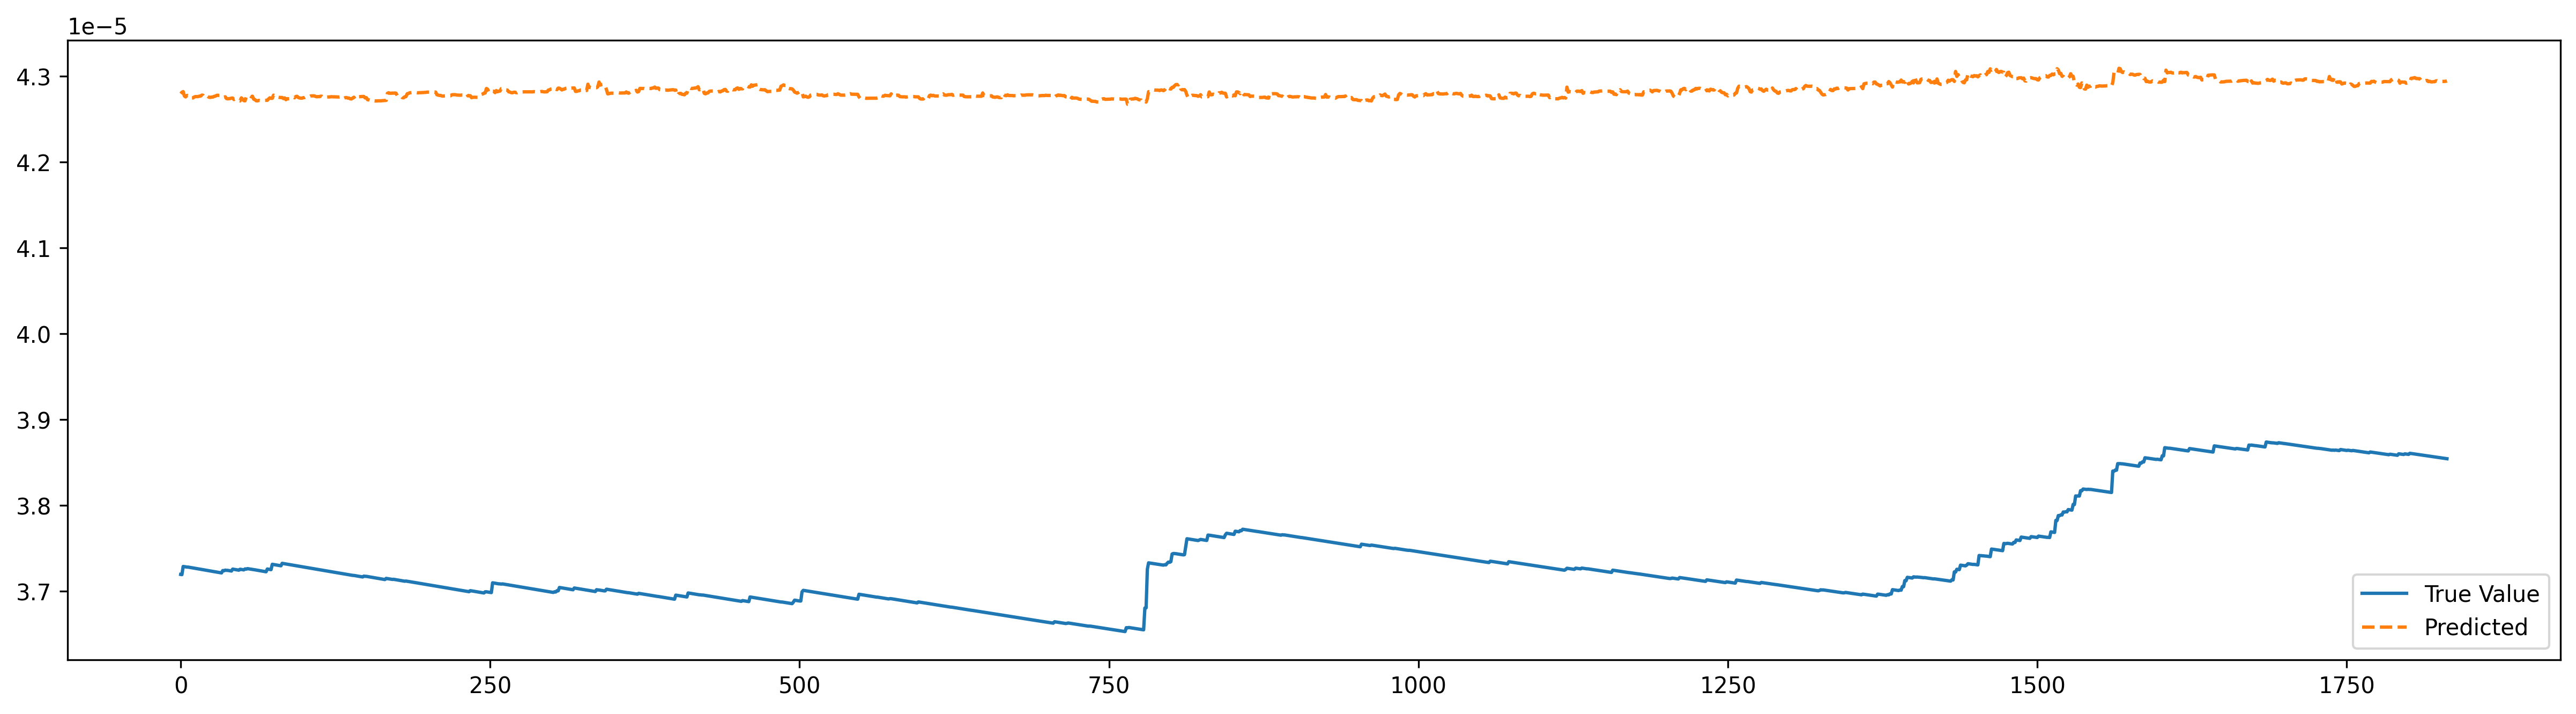

In [181]:
from sklearn.metrics import mean_absolute_error
pred = model.predict(X_test)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_test,label='True Value')
plt.plot(pred,linestyle='--', label = 'Predicted')
plt.legend()
plt.show()

In [160]:
tb_mae = np.mean(np.abs(y_test - pred))
tb_mae

1.1424856033951485e-06

229/229 [==============================] - 1s 5ms/step


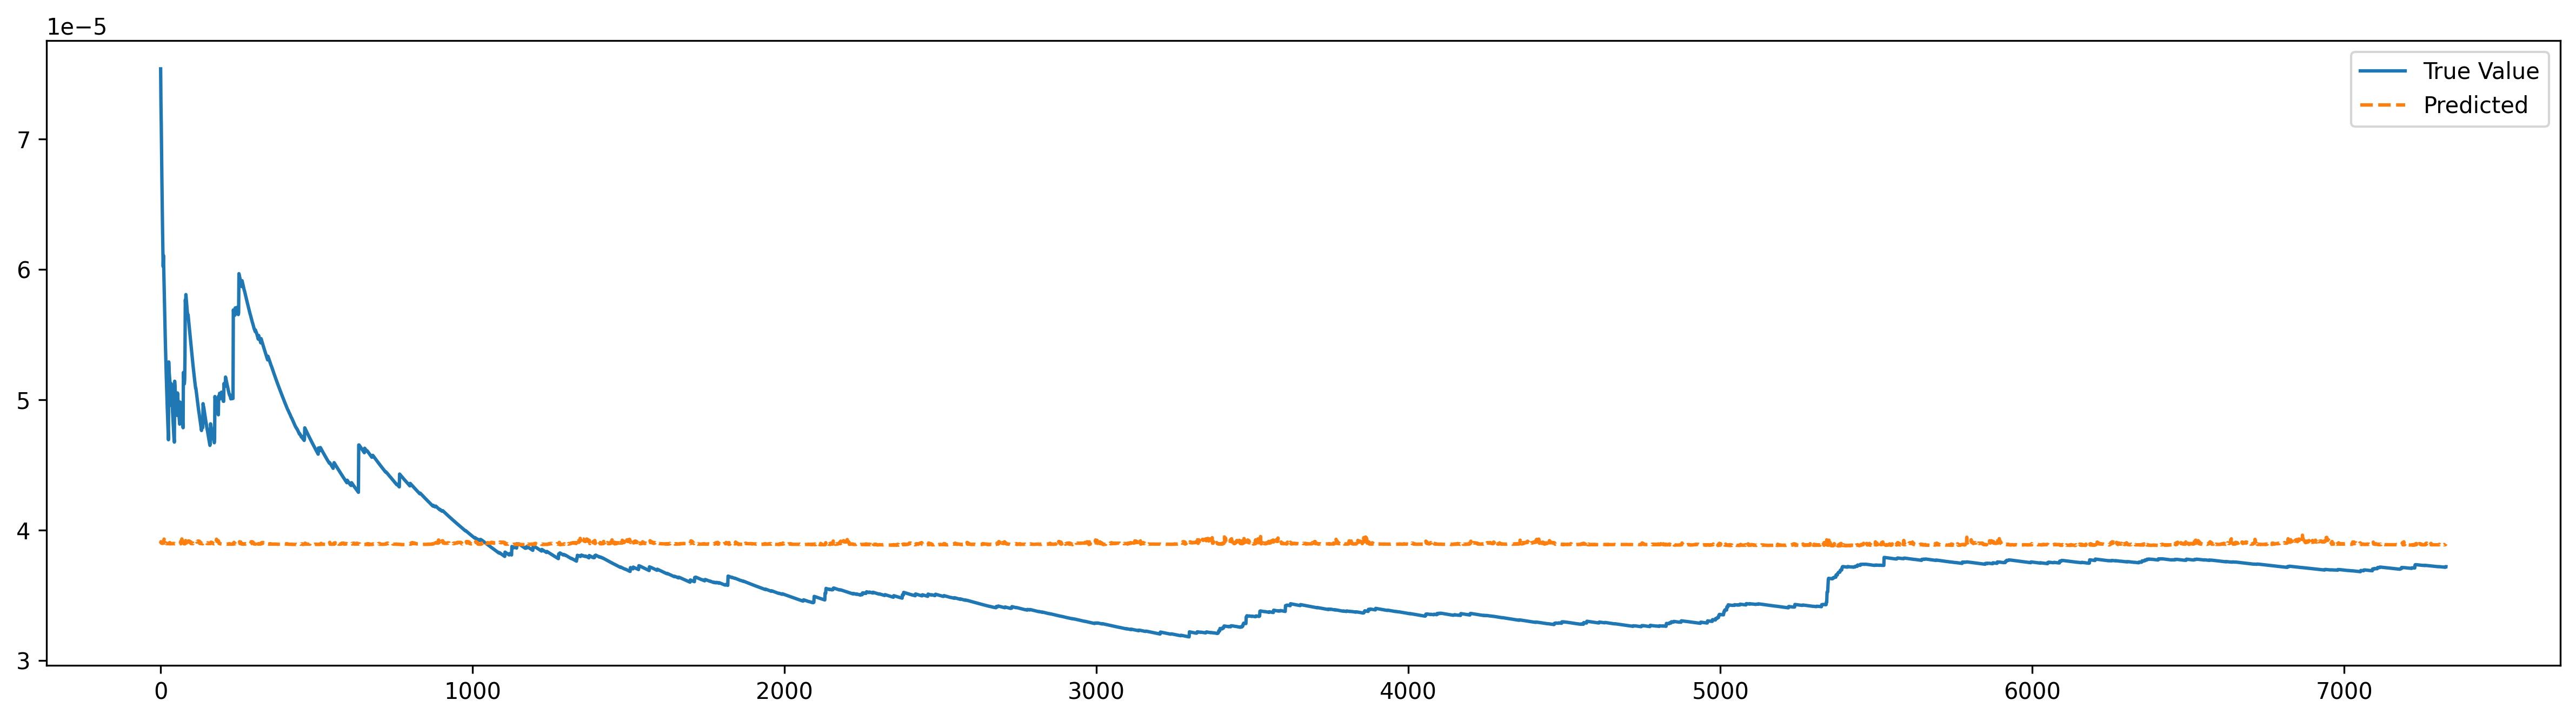

In [172]:
pred = model.predict(X_train)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_train,label='True Value')
plt.plot(pred,linestyle='--', label = 'Predicted')
plt.legend()
plt.show()

In [162]:
model.evaluate(X_test, y_test)

58/58 [==============================] - 0s 5ms/step - loss: 2.1619e-12 - mape: 3.0537


[2.1618767973713426e-12, 3.0536677837371826]

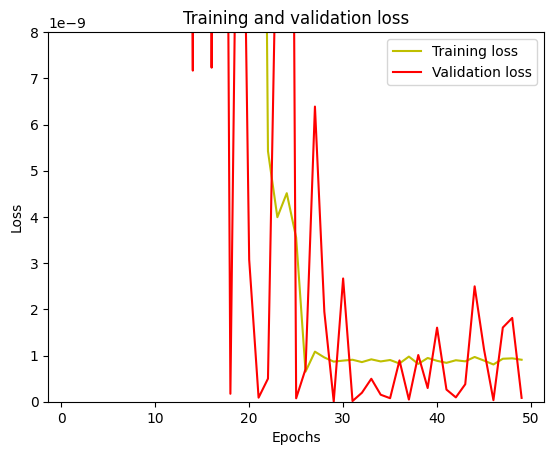

In [163]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 0.000000008)
plt.show()

# Feature Generation

In [963]:
data = pd.read_csv("/Users/yuhaoli/code/HowardLiYH/Volatility-prediction/datasets/raw/data_0401(6hrs).csv")

In [964]:
data.isnull().values.any()

False

In [1074]:
data1 = pd.read_csv('/Users/yuhaoli/code/HowardLiYH/Volatility-prediction/datasets/raw/data0329.csv')

In [966]:
columns_name = list(data1.columns)[:-2]

In [1078]:
data1.columns

Index(['bp_1', 'bz_1', 'bp_2', 'bz_2', 'bp_3', 'bz_3', 'bp_4', 'bz_4', 'bp_5',
       'bz_5', 'bp_6', 'bz_6', 'bp_7', 'bz_7', 'bp_8', 'bz_8', 'bp_9', 'bz_9',
       'bp_10', 'bz_10', 'bp_11', 'bz_11', 'bp_12', 'bz_12', 'bp_13', 'bz_13',
       'bp_14', 'bz_14', 'bp_15', 'bz_15', 'bp_16', 'bz_16', 'bp_17', 'bz_17',
       'bp_18', 'bz_18', 'bp_19', 'bz_19', 'bp_20', 'bz_20', 'ap_1', 'az_1',
       'ap_2', 'az_2', 'ap_3', 'az_3', 'ap_4', 'az_4', 'ap_5', 'az_5', 'ap_6',
       'az_6', 'ap_7', 'az_7', 'ap_8', 'az_8', 'ap_9', 'az_9', 'ap_10',
       'az_10', 'ap_11', 'az_11', 'ap_12', 'az_12', 'ap_13', 'az_13', 'ap_14',
       'az_14', 'ap_15', 'az_15', 'ap_16', 'az_16', 'ap_17', 'az_17', 'ap_18',
       'az_18', 'ap_19', 'az_19', 'ap_20', 'az_20', 'scrape_time',
       'lastUpdateId'],
      dtype='object')

In [967]:
data = data.iloc[:,2:]

In [968]:
data1

,bp_1,bz_1,bp_2,bz_2,bp_3,bz_3,bp_4,bz_4,bp_5,bz_5,...,ap_17,az_17,ap_18,az_18,ap_19,az_19,ap_20,az_20,scrape_time,lastUpdateId
0,27215.98,3.62823,27215.71,0.09094,27215.15,0.06106,27215.14,0.10176,27213.06,0.11000,...,27220.22,0.18378,27220.24,0.18378,27220.40,0.38577,27220.87,0.73017,2023-03-28 19:33:30,17688482161
1,27219.01,2.49441,27218.96,0.40455,27218.95,0.81592,27218.94,0.56887,27218.86,0.51754,...,27221.64,0.05013,27221.79,0.03673,27222.27,0.04246,27222.44,0.03673,2023-03-28 19:33:24,17688480766
2,27219.01,0.53591,27218.72,0.41551,27218.71,0.07000,27218.40,0.00671,27218.36,0.57475,...,27223.09,0.22057,27223.10,0.36755,27223.24,0.46670,27223.25,0.00367,2023-03-28 19:33:19,17688480114
3,27223.23,6.40427,27221.59,1.00260,27221.39,0.03674,27221.36,1.10536,27221.34,1.10536,...,27227.34,0.18374,27227.92,1.06032,27228.39,1.21947,27228.40,2.03245,2023-03-28 19:33:36,17688483548
4,27223.23,0.48052,27222.67,0.48829,27222.40,0.09468,27222.29,0.57712,27222.22,0.00921,...,27227.34,0.36748,27228.05,0.03622,27228.07,1.01425,27228.08,0.78360,2023-03-28 19:33:07,17688478201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639,26930.46,5.33370,26930.45,0.00316,26930.37,0.03715,26930.31,0.61962,26930.30,0.02100,...,26934.48,0.00076,26934.51,0.18575,26934.55,0.64260,26934.56,1.07101,2023-03-28 09:57:44,17681597926
2640,26930.46,5.77308,26930.37,0.03715,26930.31,0.61962,26930.30,0.02100,26930.28,1.10540,...,26934.57,0.00081,26934.67,0.00282,26934.86,0.01500,26935.00,0.10855,2023-03-28 09:57:38,17681597775
2641,26931.30,8.17244,26931.23,1.10536,26931.22,0.09094,26931.11,0.58155,26931.02,1.10536,...,26933.06,0.70284,26933.33,0.01277,26933.61,0.76224,26933.81,0.58400,2023-03-28 09:56:30,17681587296
2642,26931.30,8.64483,26931.24,0.90942,26931.23,1.10536,26931.02,1.10536,26931.01,0.90942,...,26933.95,1.00681,26934.09,0.00129,26934.29,0.01500,26934.30,0.00076,2023-03-28 09:56:24,17681586783


In [969]:
data.columns = columns_name

In [970]:
## Spread
data['spread'] = ((data['ap_1']/data['bp_1']) - 1)

In [971]:
# Weighted Average Price 
data['WAP'] = (data['bp_1']*data['bz_1']
               +data['bp_2']*data['bz_2']
               +data['ap_1']*data['az_1']
               +data['ap_2']*data['az_2'])/(data['bz_1']+
                                         data['bz_2']+
                                         data['az_1']+
                                         data['az_2'])

In [972]:
# Weighted Average Price 
data['WAP'] = (data['bp_1']*data['bz_1']
               +data['bp_2']*data['bz_2']
               +data['ap_1']*data['az_1']
               +data['ap_2']*data['az_2'])/(data['bz_1']+
                                         data['bz_2']+
                                         data['az_1']+
                                         data['az_2'])

In [973]:
## Log price

def log_price(list_stock_prices):
    return np.log(list_stock_prices)

data.insert(0, 'log_price', log_price(data['WAP']))

data['log_returns'] = data.log_price.diff()

In [974]:
## Realized Volatility
def realized_volatility():
    list_vol = []
    i = 0
    for i in data.index:
        x = np.std(data.log_returns.iloc[:i])
        i += 1
        list_vol.append(x)
    
    return list_vol

data['realized_volatility'] = realized_volatility()

In [975]:
## Previous volatility

data['volatility_t+1'] = data['realized_volatility'].shift(-1)


In [977]:
#sum of all bid quantities
data['bid depth'] = data[['bz_1', 'bz_2', 'bz_3','bz_4', 'bz_5', 'bz_6','bz_7', 'bz_8', 'bz_9','bz_10',
                         'bz_11', 'bz_12', 'bz_13','bz_14', 'bz_15', 'bz_16','bz_17', 'bz_18', 'bz_19','bz_20']].sum(axis=1)

In [978]:
#sum of all bid quantities
data['ask depth'] = data[['az_1', 'az_2', 'az_3','az_4', 'az_5', 'az_6','az_7', 'az_8', 'az_9','az_10',
                         'az_11', 'az_12', 'az_13','az_14', 'az_15', 'az_16','az_17', 'az_18', 'az_19','az_20']].sum(axis=1)

In [979]:
## Bid-ask Imbalance
data['bid_ask_imbalance'] = (data['bid depth'] - data['ask depth']) / (data['bid depth'] + data['ask depth'])

In [981]:
df = data.copy()

In [982]:
df

,log_price,bp_1,bz_1,bp_2,bz_2,bp_3,bz_3,bp_4,bz_4,bp_5,...,az_20,spread,WAP,log_returns,realized_volatility,volatility_t+1,bid depth,ask depth,bid_ask_imbalance,log price
0,10.257406,28492.26,0.00037,28492.00,0.00176,28491.11,0.00377,28491.00,0.00176,28490.75,...,0.01999,3.509725e-07,28492.785074,NaN,NaN,NaN,3.82167,12.96359,-0.544640,10.257406
1,10.257381,28492.00,0.02180,28491.93,0.08660,28491.11,0.00377,28491.00,0.00176,28490.67,...,0.47363,3.509757e-07,28492.058999,-2.548312e-05,NaN,0.000000,4.86119,12.10093,-0.426818,10.257381
2,10.257332,28490.55,0.70889,28490.54,0.91462,28490.00,0.00275,28489.85,0.06192,28489.84,...,0.03038,3.509936e-07,28490.672797,-4.865340e-05,0.000000,0.000012,5.15110,10.24836,-0.331003,10.257332
3,10.257309,28490.00,1.89468,28489.97,0.60454,28489.84,0.10000,28489.83,0.24396,28489.65,...,0.02287,3.510004e-07,28490.008547,-2.331490e-05,0.000012,0.000011,5.83333,8.03665,-0.158855,10.257309
4,10.257309,28490.00,1.77856,28489.84,0.10000,28489.83,0.24396,28489.65,0.00312,28489.31,...,0.08000,3.510004e-07,28490.008529,-6.388916e-10,0.000011,0.000017,5.69514,9.36146,-0.243503,10.257309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9168,10.253968,28395.00,1.38557,28394.94,0.53725,28394.92,2.25094,28394.76,0.92475,28394.33,...,0.00070,3.521747e-07,28394.998642,0.000000e+00,0.000039,0.000039,7.99293,6.88169,0.074707,10.253968
9169,10.253968,28395.00,1.38441,28394.94,0.53725,28394.92,2.25094,28394.75,0.01778,28394.33,...,0.00618,3.521747e-07,28394.998162,-1.691898e-08,0.000039,0.000039,7.80102,6.75659,0.071745,10.253968
9170,10.253967,28395.00,1.30573,28394.92,2.25094,28394.75,0.01778,28394.33,0.00081,28393.85,...,0.00618,3.521747e-07,28394.970149,-9.865364e-07,0.000039,0.000039,7.38509,6.75659,0.044443,10.253967
9171,10.253968,28395.00,1.67925,28394.92,1.17915,28394.33,0.00081,28393.80,0.61716,28393.37,...,0.00618,3.521747e-07,28394.987944,6.267057e-07,0.000039,0.000039,7.98389,7.42229,0.036453,10.253968


In [983]:
data.drop(['bp_1','bp_2','bp_3','bp_4','bp_5','bp_6','bp_7','bp_8','bp_9','bp_10','bp_11','bp_12','bp_13','bp_14','bp_15','bp_16','bp_17','bp_18','bp_19','bp_20',
          'bz_1','bz_2','bz_3','bz_4','bz_5','bz_6','bz_7','bz_8','bz_9','bz_10','bz_11','bz_12','bz_13','bz_14','bz_15','bz_16','bz_17','bz_18','bz_19','bz_20',
          'ap_1','ap_2','ap_3','ap_4','ap_5','ap_6','ap_7','ap_8','ap_9','ap_10','ap_11','ap_12','ap_13','ap_14','ap_15','ap_16','ap_17','ap_18','ap_19','ap_20',
            'az_1','az_2','az_3','az_4','az_5','az_6','az_7','az_8','az_9','az_10','az_11','az_12','az_13','az_14','az_15','az_16','az_17','az_18','az_19','az_20'],axis=1, inplace=True)
          

In [984]:
df

,log_price,bp_1,bz_1,bp_2,bz_2,bp_3,bz_3,bp_4,bz_4,bp_5,...,az_20,spread,WAP,log_returns,realized_volatility,volatility_t+1,bid depth,ask depth,bid_ask_imbalance,log price
0,10.257406,28492.26,0.00037,28492.00,0.00176,28491.11,0.00377,28491.00,0.00176,28490.75,...,0.01999,3.509725e-07,28492.785074,NaN,NaN,NaN,3.82167,12.96359,-0.544640,10.257406
1,10.257381,28492.00,0.02180,28491.93,0.08660,28491.11,0.00377,28491.00,0.00176,28490.67,...,0.47363,3.509757e-07,28492.058999,-2.548312e-05,NaN,0.000000,4.86119,12.10093,-0.426818,10.257381
2,10.257332,28490.55,0.70889,28490.54,0.91462,28490.00,0.00275,28489.85,0.06192,28489.84,...,0.03038,3.509936e-07,28490.672797,-4.865340e-05,0.000000,0.000012,5.15110,10.24836,-0.331003,10.257332
3,10.257309,28490.00,1.89468,28489.97,0.60454,28489.84,0.10000,28489.83,0.24396,28489.65,...,0.02287,3.510004e-07,28490.008547,-2.331490e-05,0.000012,0.000011,5.83333,8.03665,-0.158855,10.257309
4,10.257309,28490.00,1.77856,28489.84,0.10000,28489.83,0.24396,28489.65,0.00312,28489.31,...,0.08000,3.510004e-07,28490.008529,-6.388916e-10,0.000011,0.000017,5.69514,9.36146,-0.243503,10.257309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9168,10.253968,28395.00,1.38557,28394.94,0.53725,28394.92,2.25094,28394.76,0.92475,28394.33,...,0.00070,3.521747e-07,28394.998642,0.000000e+00,0.000039,0.000039,7.99293,6.88169,0.074707,10.253968
9169,10.253968,28395.00,1.38441,28394.94,0.53725,28394.92,2.25094,28394.75,0.01778,28394.33,...,0.00618,3.521747e-07,28394.998162,-1.691898e-08,0.000039,0.000039,7.80102,6.75659,0.071745,10.253968
9170,10.253967,28395.00,1.30573,28394.92,2.25094,28394.75,0.01778,28394.33,0.00081,28393.85,...,0.00618,3.521747e-07,28394.970149,-9.865364e-07,0.000039,0.000039,7.38509,6.75659,0.044443,10.253967
9171,10.253968,28395.00,1.67925,28394.92,1.17915,28394.33,0.00081,28393.80,0.61716,28393.37,...,0.00618,3.521747e-07,28394.987944,6.267057e-07,0.000039,0.000039,7.98389,7.42229,0.036453,10.253968


In [985]:
## Take out NAN and 0

data = data.iloc[3:-1,:]

In [986]:
######## More features ############
# #Here is a list of them:
# 1. Historical Price Data (?)
# 2. Market Sentiment Analysis (?)
#########################################
# 3. Bid-ask Imbalance ✅ 
# 4. Order Flow imbalance ✅ 
# 5. Total Depth ✅ 
# 6. Price Levels ✅ 
# 7. Order Imbalance Ratio ☑️ 
# 8. Order Book Imbalance ☑️ 
# 9. Time-Weighted Average Price (TWAP) ✅ 
# 10.Price Momentum ✅ 
# 11.Volatility Indicators ✅ 
# 12.Order Book Density ❌
# 13.Liquidity ✅ 
# 14.Order Book Slope ✅ 
# 15.Order Book Correlation (both size and price) ✅ 
# 16.Time Series Indicators ✅ (SMA, EMA, No RSI)
# 17.Bid-Ask Volume Ratio ☑️
# 18.Bid-Ask Cumulative Volume ✅
# 19.Order Book Shape ✅
# 20.Order Book Slope Direction ❌
# 21.Order Book Momentum ✅
# 22.Order Book Velocity ✅
# 23.Bid-Ask Price Ratio ✅
# 24.Order Book Density Slope ✅
# 25.Order Book Density Velocity ✅
# 26.Bid-Ask Spread Percentage ✅
# 27.Order Book Weighted Price ✅
# 28.Bid-Ask Spread Direction ❌
# 29.Bid-Ask Spread Velocity ✅
# 30.Order Book Range ✅
# 31.Order Book Stability ✅
# 32.Order Book Diversity ✅
# 33.Price Level Spread ✅
###########################################

In [987]:
## Bid-ask Imbalance
data['bid_ask_imbalance'] = (data['bid depth'] - data['ask depth']) / (data['bid depth'] + data['ask depth'])

In [988]:
## total volume 
## market buy voleume 
## market seell volume
################# Order Flow Imbalance
data['total_volume'] = data['bid depth'] + data['ask depth']
data['market_sell_volume'] = df[['bz_1', 'bz_2', 'bz_3','bz_4', 'bz_5']].sum(axis=1)
data['market_buy_volume'] = df[['az_1', 'az_2', 'az_3','az_4', 'az_5']].sum(axis=1)
data['order_flow_imbalance'] = (data['market_buy_volume'] - data['market_sell_volume'])/data['total_volume'] 

In [989]:
## Price Levels
data['price_level'] = (df['bp_1'] + df['ap_1'])/2

In [ ]:
df = df.iloc[3:-1,:]

In [1011]:
df = df.reset_index()

In [1012]:
df

,index,log_price,bp_1,bz_1,bp_2,bz_2,bp_3,bz_3,bp_4,bz_4,...,az_20,spread,WAP,log_returns,realized_volatility,volatility_t+1,bid depth,ask depth,bid_ask_imbalance,log price
0,3,10.257309,28490.00,1.89468,28489.97,0.60454,28489.84,0.10000,28489.83,0.24396,...,0.02287,3.510004e-07,28490.008547,-2.331490e-05,0.000012,0.000011,5.83333,8.03665,-0.158855,10.257309
1,4,10.257309,28490.00,1.77856,28489.84,0.10000,28489.83,0.24396,28489.65,0.00312,...,0.08000,3.510004e-07,28490.008529,-6.388916e-10,0.000011,0.000017,5.69514,9.36146,-0.243503,10.257309
2,5,10.257272,28488.92,0.06103,28488.39,0.00215,28488.21,0.03686,28488.12,0.18249,...,0.05019,3.510137e-07,28488.951433,-3.710478e-05,0.000017,0.000016,4.88340,8.58175,-0.274661,10.257272
3,6,10.257270,28488.92,1.18773,28488.71,0.81351,28488.12,0.18249,28488.11,0.71669,...,0.48003,3.510137e-07,28488.909106,-1.485751e-06,0.000016,0.000018,7.79497,10.60699,-0.152811,10.257270
4,7,10.257271,28488.92,1.18425,28488.00,0.00088,28487.81,0.11098,28487.80,0.81554,...,0.48004,3.510137e-07,28488.943606,1.210985e-06,0.000018,0.000018,5.86444,10.07692,-0.264248,10.257271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9164,9167,10.253968,28395.00,1.38557,28394.94,0.53725,28394.92,2.25094,28394.76,0.92475,...,0.00070,3.521747e-07,28394.998642,1.027610e-06,0.000039,0.000039,7.99293,6.88169,0.074707,10.253968
9165,9168,10.253968,28395.00,1.38557,28394.94,0.53725,28394.92,2.25094,28394.76,0.92475,...,0.00070,3.521747e-07,28394.998642,0.000000e+00,0.000039,0.000039,7.99293,6.88169,0.074707,10.253968
9166,9169,10.253968,28395.00,1.38441,28394.94,0.53725,28394.92,2.25094,28394.75,0.01778,...,0.00618,3.521747e-07,28394.998162,-1.691898e-08,0.000039,0.000039,7.80102,6.75659,0.071745,10.253968
9167,9170,10.253967,28395.00,1.30573,28394.92,2.25094,28394.75,0.01778,28394.33,0.00081,...,0.00618,3.521747e-07,28394.970149,-9.865364e-07,0.000039,0.000039,7.38509,6.75659,0.044443,10.253967


In [1013]:
df.drop(['index'], axis = 1, inplace=True)

In [1014]:
# bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]

In [1015]:
# bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]

In [1016]:
# ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]

In [1017]:
# ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]

In [1018]:
## Time-Weighted Average Price (TWAP)
#TWAP = (Σ(Pi * Vi)) / (ΣVi)
#Pi = price of the ith trade
#Vi = volume of the ith trade

TWAP_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    total_bid_volume = sum(bid_sizes)
    total_ask_volume = sum(ask_sizes)

    # Initialize variables for TWAP calculation
    twap_numerator = 0
    twap_denominator = 0
    time_interval = 60  # in seconds
    total_time = time_interval * len(bid_prices)

    # Calculate TWAP
    for i in range(len(bid_prices)):
        mid_price = (bid_prices[i] + ask_prices[i]) / 2
        volume = min(bid_sizes[i], ask_sizes[i])
        twap_numerator += mid_price * volume * time_interval
        twap_denominator += volume * time_interval

    TWAP = twap_numerator / twap_denominator
    TWAP_list.append(TWAP)
    
data['TWAP'] = TWAP_list

In [1019]:
## Price Moementum 

PriceM_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]

    time_diff = 5
    price_momentum = (bid_prices[-1] - bid_prices[-2]) / time_diff
    PriceM_list.append(price_momentum)


data['price_momentum'] = PriceM_list

In [1020]:
## Volatility Indicators

Volatility_Indicators_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    
    # Calculate price returns as the percentage change between consecutive prices
    price_returns = np.diff(bid_prices) / bid_prices[:-1]
    
    # Calculate the 5-minute rolling standard deviation of price returns
    rolling_std = np.std(price_returns[-20:]) 
    
    Volatility_Indicators_list.append(rolling_std)
    
data['Volatility_Indicators'] = Volatility_Indicators_list 

In [1021]:
## Liquidty

liquidity_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    # Set the distance from the current market price
    distance = 2

    # Calculate the liquidity at the bid side
    bid_liquidity = np.sum(bid_sizes[:distance])

    # Calculate the liquidity at the ask side
    ask_liquidity = np.sum(ask_sizes[:distance])

    # Calculate the total liquidity
    total_liquidity = bid_liquidity + ask_liquidity

    liquidity_list.append(total_liquidity)

data['liquidity'] = liquidity_list

In [1022]:
## Order book slope

order_book_slope_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    # Perform linear regression on the bid prices
    bid_model = LinearRegression().fit(np.arange(len(bid_prices)).reshape(-1, 1), bid_prices)

    # Get the bid slope coefficient
    bid_slope = bid_model.coef_[0]

    # Perform linear regression on the ask prices
    ask_model = LinearRegression().fit(np.arange(len(ask_prices)).reshape(-1, 1), ask_prices)

    # Get the ask slope coefficient
    ask_slope = ask_model.coef_[0]

    # Calculate the average slope as the order book slope
    order_book_slope = (bid_slope + ask_slope) / 2
    order_book_slope_list.append(order_book_slope)


data['order_book_slope'] = order_book_slope_list

In [1023]:
## Order book correlation

correlation_size_list = []
correlation_price_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    # Calculate the correlation coefficient between bid and ask sizes
    correlation_size = np.corrcoef(bid_sizes, ask_sizes)[0][1]
    correlation_size_list.append(correlation_size)

    # Calculate the correlation coefficient between bid and ask prices
    correlation_price = np.corrcoef(bid_prices, ask_prices)[0][1]
    correlation_price_list.append(correlation_price)
    

data['correlation_size'] = correlation_size_list
data['correlation_price'] = correlation_price_list

In [1024]:
## Time Series Indicators
# SMA
# EMA

SMA_list = []
EMA_list = []


for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    closing_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    
    # Calculate a 12-period simple moving average
    periods = 12
    sma = np.mean(closing_prices[-periods:])
    SMA_list.append(sma)
    
    # Create a pandas DataFrame with the closing prices
    df_ema = pd.DataFrame({"Close": closing_prices})
    ema = df_ema["Close"].ewm(span=periods, adjust=False).mean().iloc[-1]
    EMA_list.append(ema)


data['SMA'] = SMA_list
data['EMA'] = EMA_list

In [1025]:
# ################ Not Obviosu #######################
# ## Time Series Indicators
# # RSI 

# RSI_list = []

# for index, row in df.iterrows():
#     test_df = df.iloc[index,:]
#     closing_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    
#     # Calculate the difference between each closing price and the previous closing price
#     price_diff = [closing_prices[i] - closing_prices[i-1] for i in range(1, len(closing_prices))]

#     # Separate the positive price differences from the negative price differences
#     positive_diff = [val if val > 0 else 0 for val in price_diff]
#     negative_diff = [abs(val) if val < 0 else 0 for val in price_diff]

#     # Calculate the average gain and average loss over a window of 14 periods
#     window = 14
#     avg_gain = sum(positive_diff[:window]) / window
#     avg_loss = sum(negative_diff[:window]) / window

#     # Calculate the first RSI value using the average gain and average loss
#     rs = avg_gain / avg_loss
#     rsi = 100 - (100 / (1 + rs))

#     # Calculate the remaining RSI values using a smoothing factor of 1/14
#     smoothing_factor = 1 / window
#     for i in range(window, len(closing_prices)-1):
#         curr_price_diff = closing_prices[i] - closing_prices[i-1]
#         curr_positive_diff = curr_price_diff if curr_price_diff > 0 else 0
#         curr_negative_diff = abs(curr_price_diff) if curr_price_diff < 0 else 0
#         avg_gain = (avg_gain * (window-1) + curr_positive_diff) / window
#         avg_loss = (avg_loss * (window-1) + curr_negative_diff) / window
#         rs = avg_gain / avg_loss
#         rsi = (rsi * (1 - smoothing_factor)) + (smoothing_factor * (100 - (100 / (1 + rs))))

#     RSI_list.append(rsi)
    
# data['RSI'] = RSI_list

In [1026]:
# data.drop('RSI',axis=1,inplace=True)

In [1027]:
## Bid-Ask culmulative volume

bid_ask_cumulative_volume_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    
    bid_volume = bid_sizes * (bid_prices - min(bid_prices))
    ask_volume = ask_sizes * (max(ask_prices) - ask_prices)

    bid_cumulative_volume = np.cumsum(bid_volume)
    ask_cumulative_volume = np.cumsum(ask_volume)
    bid_ask_cumulative_volume_ratio = bid_cumulative_volume[-1] / ask_cumulative_volume[-1]
    bid_ask_cumulative_volume_list.append(bid_ask_cumulative_volume_ratio)

data['bid_ask_cumulative_volume'] = bid_ask_cumulative_volume_list

In [1028]:
## order book shape

order_book_shape_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    n_levels = 10 # consider the top 10 levels
    order_book_shape = sum(bid_sizes[:n_levels]) - sum(ask_sizes[:n_levels])
    
    order_book_shape_list.append(order_book_shape)
    
data['order_book_shape'] = order_book_shape_list

In [1029]:

def calculate_obsd(bid_prices, ask_prices, period):
    # Calculate the slope of the bid and ask prices over the specified period
    bid_slope = np.sign(np.gradient(bid_prices[-period:]))
    ask_slope = np.sign(np.gradient(ask_prices[-period:]))

    # Calculate the OBSD
    obsd = np.sign(bid_slope[-1] + ask_slope[-1])

    return obsd

In [1030]:
# ################# Not going to use #############
# ## OBSD order book slope direction

# obsd_list = []
# period = 8

# for index, row in df.iterrows():
#     test_df = df.iloc[index,:]
#     bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
#     ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
   
#     obsd = calculate_obsd(bid_prices, ask_prices, period)
#     obsd_list.append(obsd)

# data['obsd'] = obsd_list

In [1031]:
# data.drop('obsd',axis=1,inplace=True)

In [ ]:
## Order Book momentum

order_book_momentum_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    # Calculate total volume
    total_volume = sum(bid_sizes) + sum(ask_sizes)

    # Calculate differences between adjacent bid sizes
    bid_size_diffs = [abs(bid_sizes[i] - bid_sizes[i+1]) for i in range(len(bid_sizes)-1)]

    # Calculate differences between adjacent ask sizes
    ask_size_diffs = [abs(ask_sizes[i] - ask_sizes[i+1]) for i in range(len(ask_sizes)-1)]

    # Calculate sum of differences
    sum_diffs = sum(bid_size_diffs) + sum(ask_size_diffs)

    # Calculate order book momentum
    order_book_momentum = sum_diffs / total_volume
    order_book_momentum_list.append(order_book_momentum)

data['order_book_momentum'] = order_book_momentum_list

In [ ]:
data

In [1034]:
## Order Book velocity

order_book_velocity_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    # Calculate bid-ask spreads
    spreads = np.array(ask_prices) - np.array(bid_prices)

    # Calculate percentage change in spreads
    spread_changes = np.diff(spreads) / spreads[:-1]

    # Calculate order book velocity
    order_book_velocity = spread_changes[-1]
    order_book_velocity_list.append(order_book_velocity)

data['order_book_velocity'] = order_book_velocity_list

In [1035]:
## Bid-Ask Price Ratio

bid_ask_price_ratio_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    total_bid_size = sum(bid_sizes)
    total_ask_size = sum(ask_sizes)

    weighted_avg_bid_price = sum([bid_prices[i] * bid_sizes[i] for i in range(len(bid_prices))]) / total_bid_size
    weighted_avg_ask_price = sum([ask_prices[i] * ask_sizes[i] for i in range(len(ask_prices))]) / total_ask_size
    bid_ask_price_ratio = weighted_avg_bid_price / weighted_avg_ask_price
    bid_ask_price_ratio_list.append(bid_ask_price_ratio)

    
data['bid_ask_price_ratio'] = bid_ask_price_ratio_list

In [1036]:
## Order Book Density Slope
order_book_density_slope_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    total_bid_size = sum(bid_sizes)
    total_ask_size = sum(ask_sizes)
    order_book_density_slope = (total_bid_volume - total_ask_volume) / (total_bid_volume + total_ask_volume)
    order_book_density_slope_list.append(order_book_density_slope)
    
data['order_book_density_slope'] = order_book_density_slope_list

In [1037]:
def order_book_density(bid_price, ask_price, bid_size, ask_size, p=0.1):
    bid_density = []
    ask_density = []
    for i in range(len(bid_price)):
        bd = sum(bid_size[i:]) / (bid_price[i] + p)
        bid_density.append(bd)
        ad = sum(ask_size[:i+1]) / (ask_price[i] - p)
        ask_density.append(ad)
    return bid_density, ask_density

def order_book_density_velocity(obd, t):
    obd_velocity = (obd[t] - obd[t-1]) / (t - (t-1))
    return obd_velocity

In [1038]:
## Order Book Density Velocity 
obd_velocity_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    # Calculate the bid-ask spread
    spread = ask_prices[0] - bid_prices[0]

    # Calculate the total bid and ask sizes
    total_bid_size = np.sum(bid_sizes)
    total_ask_size = np.sum(ask_sizes)

    # Calculate the order book density
    order_book_density = (total_bid_size + total_ask_size) / (2 * spread)

    # Calculate the previous order book density
    prev_order_book_density = (np.sum(bid_sizes[1:]) + np.sum(ask_sizes[1:])) / (2 * spread)

    # Calculate the order book density velocity
    order_book_density_velocity = order_book_density - prev_order_book_density
    obd_velocity_list.append(order_book_density_velocity)

data['order_book_density_velocity'] = obd_velocity_list

In [1039]:
## Bid-Ask Spread Percentage

spread_prec_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
   
    mid_prices = [(bid_prices[i] + ask_prices[i]) / 2 for i in range(len(bid_prices))]
    spread_perc = ((ask_prices[-1] - bid_prices[-1]) / mid_prices[-1]) * 100
    spread_prec_list.append(spread_perc)


    
data['spread_prec'] = spread_prec_list

In [1040]:
def weighted_price(bid_prices, ask_prices, bid_sizes, ask_sizes):
    total_size = sum(bid_sizes) + sum(ask_sizes)
    if total_size == 0:
        return None
    bid_sum = sum([bid_prices[i] * bid_sizes[i] for i in range(len(bid_prices))])
    ask_sum = sum([ask_prices[i] * ask_sizes[i] for i in range(len(ask_prices))])
    return (bid_sum + ask_sum) / total_size

In [1041]:
## Order Book Weighted

ob_weighted_price_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    ob_weighted_price = weighted_price(bid_prices, ask_prices, bid_sizes, ask_sizes)
    ob_weighted_price_list.append(ob_weighted_price)
    
data['ob_weighted_price'] = ob_weighted_price_list

In [1042]:
# ## Bid-Ask Spread Direction

# ba_spread_direction_list = []

# for index, row in df.iterrows():
#     test_df = df.iloc[index,:]
#     bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
#     ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
#     bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
#     ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]

#     # assuming bid_prices, ask_prices, bid_sizes, and ask_sizes are arrays of length 20
#     bid = np.array(bid_prices)
#     ask = np.array(ask_prices)
#     bid_vol = np.array(bid_sizes)
#     ask_vol = np.array(ask_sizes)
    
#     spread = ask[0] - bid[0]  # current spread
#     prev_spread = ask[1] - bid[1]  # previous spread

#     if spread > prev_spread:
#         spread_direction = 1  # spread is widening
#     elif spread < prev_spread:
#         spread_direction = -1  # spread is narrowing
#     else:
#         spread_direction = 0  # spread is unchanged
    
#     ba_spread_direction_list.append(spread_direction)
    
# data['ba_spread_direction'] = ba_spread_direction_list

In [1043]:
def bid_ask_spread_velocity(bid_prices, ask_prices, bid_sizes, ask_sizes):
    # Calculate bid-ask spread
    bid_ask_spread = ask_prices[0] - bid_prices[0]
    
    # Calculate previous bid-ask spread
    previous_bid_ask_spread = ask_prices[1] - bid_prices[1]
    
    # Calculate bid-ask spread velocity
    bid_ask_spread_velocity = (bid_ask_spread - previous_bid_ask_spread) / previous_bid_ask_spread
    
    return bid_ask_spread_velocity

In [1044]:
## Bid-Ask Spread Velocity

ba_spread_velocity_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]

    velocity = bid_ask_spread_velocity(bid_prices, ask_prices, bid_sizes, ask_sizes)
    ba_spread_velocity_list.append(velocity)
    
data['ba_spread_velocity'] = ba_spread_velocity_list

In [1045]:
## Order Book Range

order_book_range_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]

    order_book_range = min(ask_prices) - max(bid_prices)
    order_book_range_list.append(order_book_range)
    
data['order_book_range'] = order_book_range_list

In [1046]:
def calculate_order_book_stability(bid_prices, ask_prices, window):
    """
    Calculates the order book stability as the ratio of the maximum bid-ask spread to the sum of bid and ask sizes
    within a sliding window of a given size.
    
    Args:
    bid_prices (list): list of bid prices
    ask_prices (list): list of ask prices
    window (int): size of the sliding window
    
    Returns:
    float: order book stability
    """
    bid_sizes = [1/x for x in bid_prices]
    ask_sizes = [1/x for x in ask_prices]
    
    max_spread = 0
    sum_sizes = 0
    
    for i in range(len(bid_prices)-window+1):
        prices = bid_prices[i:i+window] + ask_prices[i:i+window]
        sizes = bid_sizes[i:i+window] + ask_sizes[i:i+window]
        spread = max(prices) - min(prices)
        max_spread = max(max_spread, spread)
        sum_sizes += sum(sizes)
    
    stability = max_spread / sum_sizes
    
    return stability


order_book_stability_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]

    stability = calculate_order_book_stability(bid_prices, ask_prices, 12)
    order_book_stability_list.append(stability)

data['order_book_stability'] = order_book_stability_list

In [1047]:
## Order Book Diversity

def order_book_diversity(bid_prices, ask_prices):
    return len(set(bid_prices + ask_prices))

order_book_diversity_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]

    order_book_diversity_result = order_book_diversity(bid_prices, ask_prices)
    order_book_diversity_list.append(order_book_diversity_result)

data['order_book_diversity'] = order_book_diversity_list

In [1048]:
## price_level_spread

# Define the function for Price Level Spread
def price_level_spread(bid_prices, ask_prices):
    # Calculate the best bid and ask prices
    best_bid = max(bid_prices)
    best_ask = min(ask_prices)
    # Calculate the mid-price
    mid_price = (best_bid + best_ask) / 2
    # Calculate the bid-ask spread
    bid_ask_spread = best_ask - best_bid
    # Calculate the price level spread
    price_level_spread = bid_ask_spread / mid_price
    return price_level_spread

In [1049]:
price_level_spread_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]

    price_level_spread_result = price_level_spread(bid_prices, ask_prices)
    price_level_spread_list.append(price_level_spread_result)

data['price_level_spread'] = price_level_spread_list

In [1050]:
data

,log_price,spread,WAP,log_returns,realized_volatility,volatility_t+1,bid depth,ask depth,bid_ask_imbalance,log price,...,bid_ask_price_ratio,order_book_density_slope,order_book_density_velocity,spread_prec,ob_weighted_price,ba_spread_velocity,order_book_range,order_book_stability,order_book_diversity,price_level_spread
3,10.257309,3.510004e-07,28490.008547,-2.331490e-05,0.000012,0.000011,5.83333,8.03665,-0.158855,10.257309,...,0.999928,0.036453,120.0970,0.032748,28490.470408,-0.965517,0.01,1230.653839,40,3.510003e-07
4,10.257309,3.510004e-07,28490.008529,-6.388916e-10,0.000011,0.000017,5.69514,9.36146,-0.243503,10.257309,...,0.999930,0.036453,123.5715,0.032607,28490.421280,-0.973684,0.01,1225.367565,40,3.510003e-07
5,10.257272,3.510137e-07,28488.951433,-3.710478e-05,0.000017,0.000016,4.88340,8.58175,-0.274661,10.257272,...,0.999889,0.036453,111.2895,0.035907,28488.662534,-0.983333,0.01,1349.310287,40,3.510136e-07
6,10.257270,3.510137e-07,28488.909106,-1.485751e-06,0.000016,0.000018,7.79497,10.60699,-0.152811,10.257270,...,0.999876,0.036453,167.4525,0.034328,28489.021118,-0.964286,0.01,1289.932069,40,3.510136e-07
7,10.257271,3.510137e-07,28488.943606,1.210985e-06,0.000018,0.000018,5.86444,10.07692,-0.264248,10.257271,...,0.999877,0.036453,172.3645,0.033907,28489.112399,-0.989899,0.01,1274.100141,40,3.510136e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,10.253968,3.521747e-07,28394.998642,1.027610e-06,0.000039,0.000039,7.99293,6.88169,0.074707,10.253968,...,0.999915,0.036453,155.4315,0.036697,28394.564486,-0.967742,0.01,1369.782714,40,3.521746e-07
9168,10.253968,3.521747e-07,28394.998642,0.000000e+00,0.000039,0.000039,7.99293,6.88169,0.074707,10.253968,...,0.999915,0.036453,155.4315,0.036697,28394.564486,-0.967742,0.01,1369.782714,40,3.521746e-07
9169,10.253968,3.521747e-07,28394.998162,-1.691898e-08,0.000039,0.000039,7.80102,6.75659,0.071745,10.253968,...,0.999914,0.036453,147.9035,0.034126,28394.561593,-0.967742,0.01,1273.820271,40,3.521746e-07
9170,10.253967,3.521747e-07,28394.970149,-9.865364e-07,0.000039,0.000039,7.38509,6.75659,0.044443,10.253967,...,0.999905,0.036453,143.9695,0.035711,28394.466555,-0.969697,0.01,1332.966982,40,3.521746e-07


# Feature Selection

In [1293]:
data

,log_price,spread,WAP,log_returns,realized_volatility,volatility_t+1,bid depth,ask depth,bid_ask_imbalance,log price,...,bid_ask_price_ratio,order_book_density_slope,order_book_density_velocity,spread_prec,ob_weighted_price,ba_spread_velocity,order_book_range,order_book_stability,order_book_diversity,price_level_spread
0,10.257309,3.510004e-07,28490.008547,-2.331490e-05,0.000012,0.000011,5.83333,8.03665,-0.158855,10.257309,...,0.999928,0.036453,120.0970,0.032748,28490.470408,-0.965517,0.01,1230.653839,40,3.510003e-07
1,10.257309,3.510004e-07,28490.008529,-6.388916e-10,0.000011,0.000017,5.69514,9.36146,-0.243503,10.257309,...,0.999930,0.036453,123.5715,0.032607,28490.421280,-0.973684,0.01,1225.367565,40,3.510003e-07
2,10.257272,3.510137e-07,28488.951433,-3.710478e-05,0.000017,0.000016,4.88340,8.58175,-0.274661,10.257272,...,0.999889,0.036453,111.2895,0.035907,28488.662534,-0.983333,0.01,1349.310287,40,3.510136e-07
3,10.257270,3.510137e-07,28488.909106,-1.485751e-06,0.000016,0.000018,7.79497,10.60699,-0.152811,10.257270,...,0.999876,0.036453,167.4525,0.034328,28489.021118,-0.964286,0.01,1289.932069,40,3.510136e-07
4,10.257271,3.510137e-07,28488.943606,1.210985e-06,0.000018,0.000018,5.86444,10.07692,-0.264248,10.257271,...,0.999877,0.036453,172.3645,0.033907,28489.112399,-0.989899,0.01,1274.100141,40,3.510136e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9164,10.253968,3.521747e-07,28394.998642,1.027610e-06,0.000039,0.000039,7.99293,6.88169,0.074707,10.253968,...,0.999915,0.036453,155.4315,0.036697,28394.564486,-0.967742,0.01,1369.782714,40,3.521746e-07
9165,10.253968,3.521747e-07,28394.998642,0.000000e+00,0.000039,0.000039,7.99293,6.88169,0.074707,10.253968,...,0.999915,0.036453,155.4315,0.036697,28394.564486,-0.967742,0.01,1369.782714,40,3.521746e-07
9166,10.253968,3.521747e-07,28394.998162,-1.691898e-08,0.000039,0.000039,7.80102,6.75659,0.071745,10.253968,...,0.999914,0.036453,147.9035,0.034126,28394.561593,-0.967742,0.01,1273.820271,40,3.521746e-07
9167,10.253967,3.521747e-07,28394.970149,-9.865364e-07,0.000039,0.000039,7.38509,6.75659,0.044443,10.253967,...,0.999905,0.036453,143.9695,0.035711,28394.466555,-0.969697,0.01,1332.966982,40,3.521746e-07


In [1294]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [1295]:
# Splitting the data into features and target variable
X = data.drop(['realized_volatility','volatility_t+1','log price'], axis=1)
y = data['volatility_t+1']

### SelectKBest Method

In [1296]:
from sklearn.feature_selection import f_regression

# assuming X and y are your feature matrix and target variable
f_values, p_values = f_regression(X, y)

# sort the p_values in ascending order
p_values_sorted = np.argsort(p_values)

# select the top 10 features based on p_values
top_features = X.columns[p_values_sorted][:10]

print("The top 10 features selected using f_regression are:")
print(top_features)


The top 10 features selected using f_regression are:
Index(['ob_weighted_price', 'EMA', 'SMA', 'TWAP', 'price_level', 'WAP',
       'log_price', 'Volatility_Indicators', 'order_book_slope',
       'total_volume'],
      dtype='object')


Selected Features: Index(['log_price', 'WAP', 'total_volume', 'price_level', 'TWAP',
       'Volatility_Indicators', 'order_book_slope', 'SMA', 'EMA',
       'ob_weighted_price'],
      dtype='object')


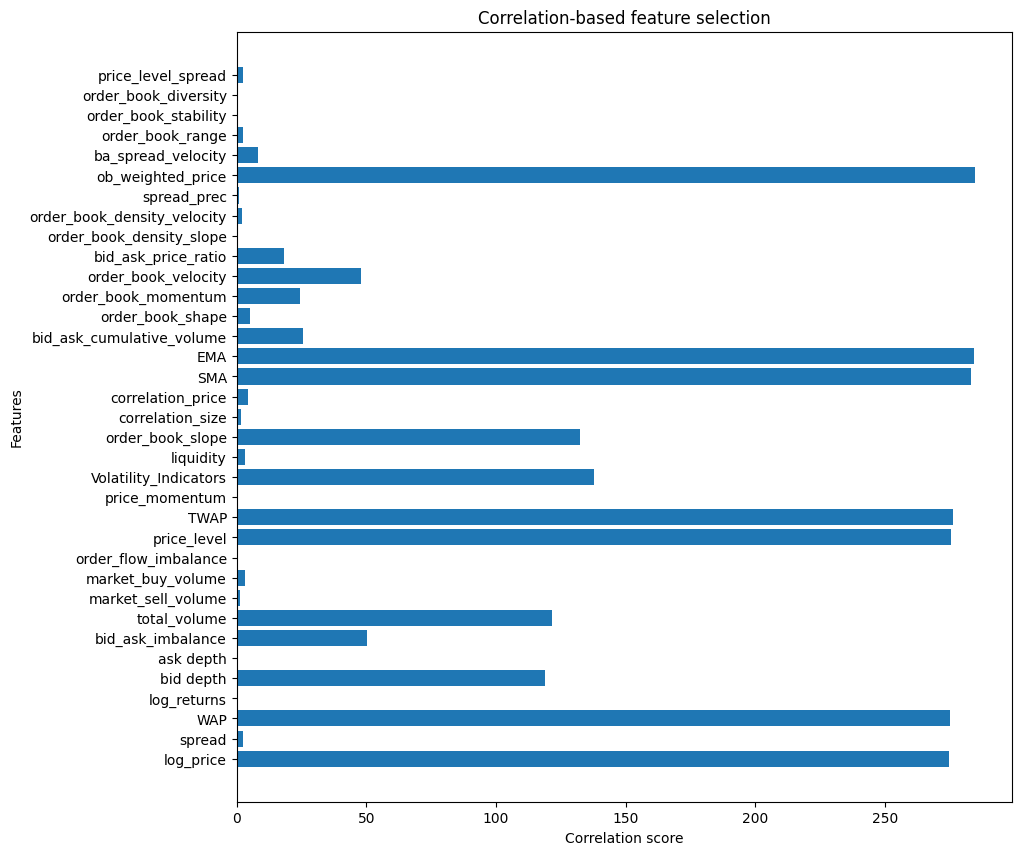

In [1333]:


# Apply correlation-based feature selection
selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(X, y)

# Get the indices of the selected features
top_indices = selector.get_support(indices=True)

# Print the names of the selected features
selected_features = X.columns[top_indices]
print('Selected Features:', selected_features)

# Plot the top 10 features
plt.figure(figsize=(10,10))
plt.barh(range(len(selector.scores_)), selector.scores_)
plt.yticks(range(len(selector.scores_)), X.columns)
plt.ylabel('Features')
plt.xlabel('Correlation score')
plt.title('Correlation-based feature selection')
plt.show()


### Recursive Feature Elimination (RFE) Method

In [1068]:
threshold = y.describe()[5] # set your threshold value
y_rfe = np.where(y >= threshold, 1, 0) # convert to binary categorical variable


In [1069]:
# Performing RFE with Random Forest Classifier
estimator = RandomForestClassifier()
selector = RFE(estimator, n_features_to_select=10, step=1)
selector.fit(X, y_rfe)
X_new = selector.transform(X)

# Printing the top 10 features selected
top_features = X.columns[selector.support_]
print("The top 10 features selected using RFE are: ")
print(top_features)


The top 10 features selected using RFE are: 
Index(['log_price', 'WAP', 'total_volume', 'price_level', 'order_book_slope',
       'SMA', 'EMA', 'bid_ask_cumulative_volume', 'ob_weighted_price',
       'order_book_stability'],
      dtype='object')


The top 10 features selected using XGBoost are:
Index(['EMA', 'bid_ask_price_ratio', 'order_book_stability', 'WAP',
       'bid_ask_cumulative_volume', 'spread', 'SMA',
       'order_book_density_velocity', 'total_volume', 'price_level'],
      dtype='object')


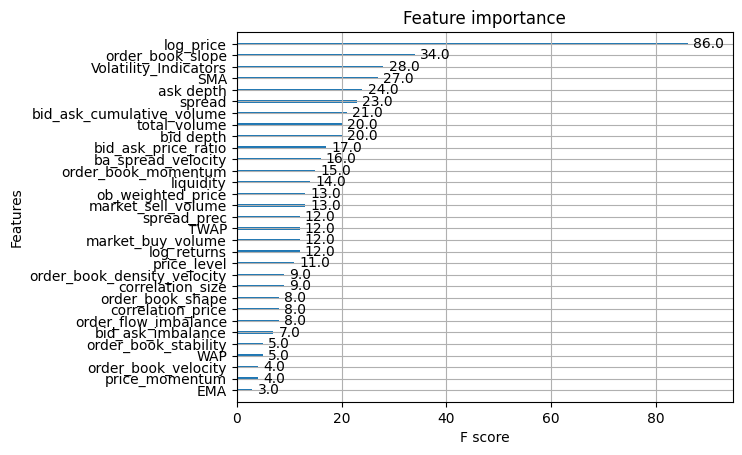

In [1070]:
import xgboost as xgb

# assuming X and y are your feature matrix and target variable
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)
xg_reg.fit(X, y_rfe)

# plot feature importances
xgb.plot_importance(xg_reg)

# select top 10 features based on feature importances
importances = xg_reg.feature_importances_
top_features = X.columns[np.argsort(importances)[-10:]]

print("The top 10 features selected using XGBoost are:")
print(top_features)


# Random Forest (4.7% mape)

In [ ]:
data = data.reset_index()
data.drop('index', axis=1, inplace=True)

Mean squared error: 7.998168210774983e-12
R-squared score: 0.6636742154001518
Feature importances: [3.00706543e-02 9.02007352e-06 3.50510859e-02 1.47775371e-02
 4.60015032e-02 2.37676924e-02 1.86851010e-02 2.86321507e-02
 3.13813313e-02 2.18041015e-02 1.52505502e-02 1.79851538e-02
 5.53895057e-02 3.92767109e-02 1.46471520e-02 6.03058107e-02
 2.27174476e-02 1.10606014e-01 1.68287070e-02 2.09209644e-02
 6.21890406e-02 5.03869810e-02 1.89626886e-02 1.43023590e-02
 2.71813650e-02 1.77056499e-02 2.79817944e-02 0.00000000e+00
 3.09442466e-02 1.86864016e-02 5.84914170e-02 2.81215341e-02
 5.42747967e-05 2.08610895e-02 0.00000000e+00 2.29646938e-05]


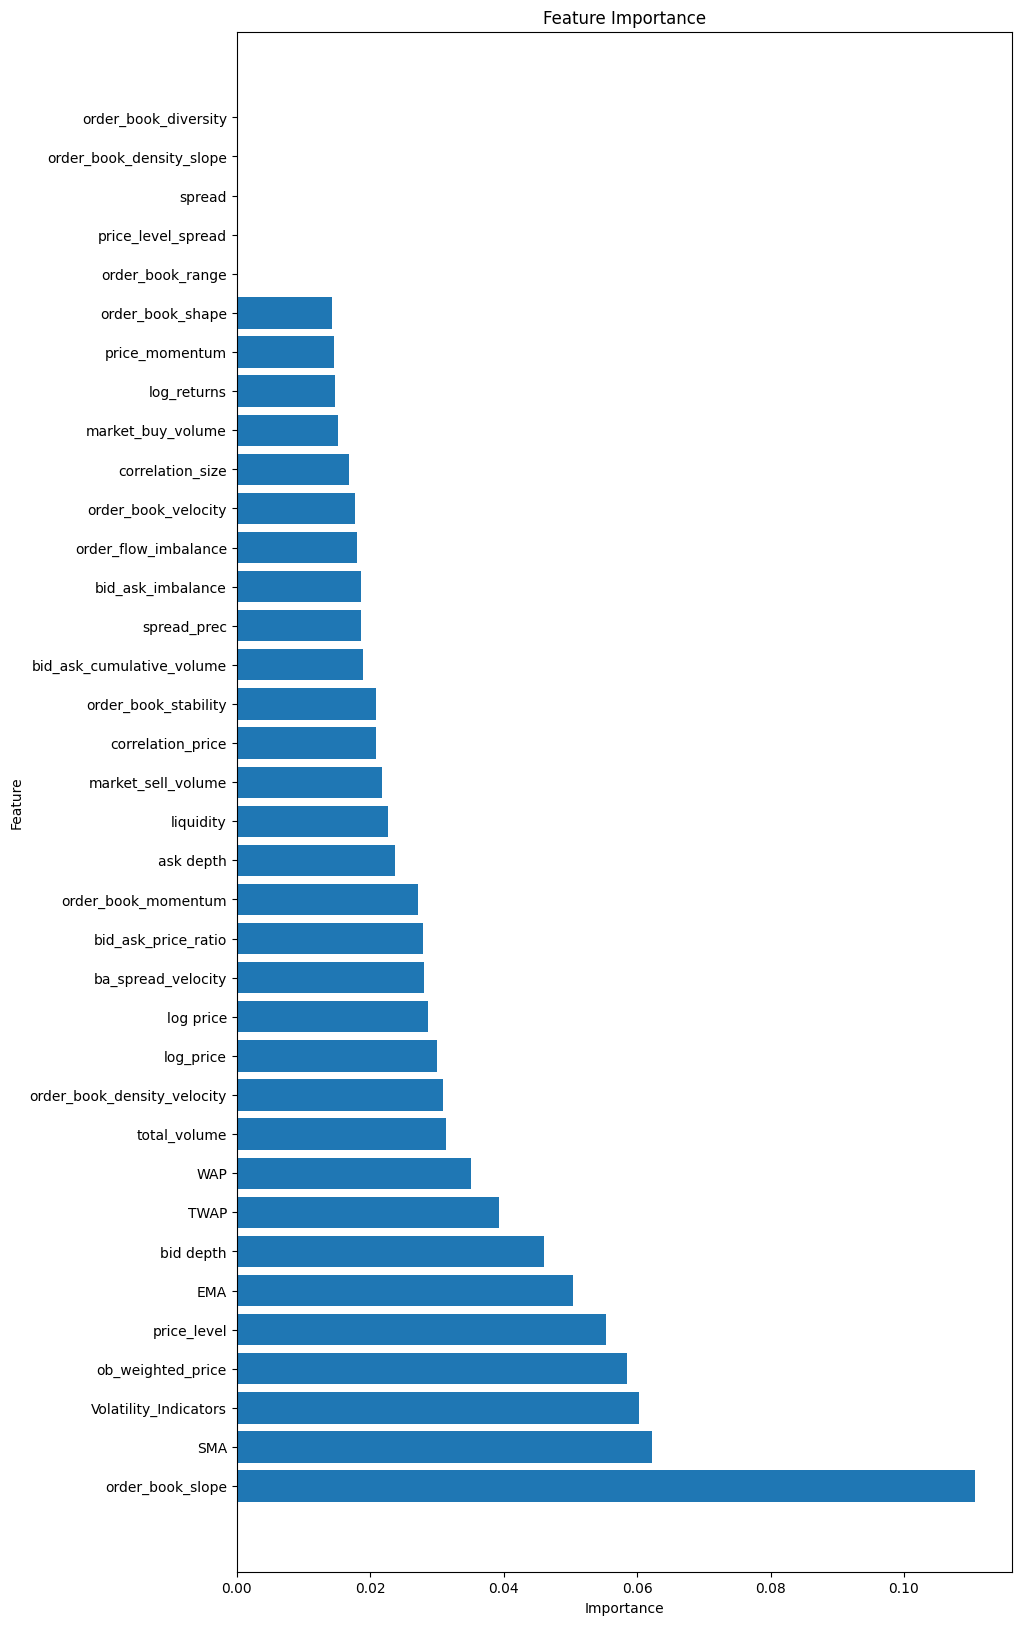

In [1085]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[['log_price', 'spread', 'WAP', 'log_returns', 'bid depth', 'ask depth', 'bid_ask_imbalance',
       'log price', 'total_volume', 'market_sell_volume', 'market_buy_volume',
       'order_flow_imbalance', 'price_level', 'TWAP', 'price_momentum',
       'Volatility_Indicators', 'liquidity', 'order_book_slope',
       'correlation_size', 'correlation_price', 'SMA', 'EMA',
       'bid_ask_cumulative_volume', 'order_book_shape', 'order_book_momentum',
       'order_book_velocity', 'bid_ask_price_ratio',
       'order_book_density_slope', 'order_book_density_velocity',
       'spread_prec', 'ob_weighted_price', 'ba_spread_velocity',
       'order_book_range', 'order_book_stability', 'order_book_diversity',
       'price_level_spread']], data['realized_volatility'], test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean squared error:', mse)
print('R-squared score:', r2)

# Get the feature importances
importances = model.feature_importances_
print('Feature importances:', importances)


# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_names = [X_train.columns[i] for i in indices]

# Plot the feature importances
plt.figure(figsize=(10,20))
plt.barh(range(X_train.shape[1]), importances[indices])
plt.yticks(range(X_train.shape[1]), sorted_names)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


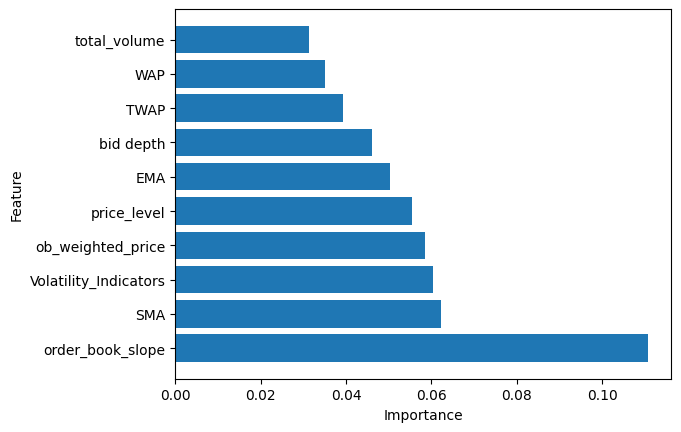

In [1086]:
# Get the feature importances
importances = model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Select the top 10 features
top_features = X_train.columns[indices][:10]

# Plot the feature importances of the top 10 features
plt.barh(range(10), importances[indices][:10])
plt.yticks(range(10), top_features)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [1174]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


# Create a new dataframe with the target variable shifted by one period
data_shifted = data.copy()
data_shifted['volatility_t+1'] = data_shifted['volatility_t+1'].shift(-1)

# Drop the last row which has NaN as the shifted value
data_shifted = data_shifted[:-1]

# Split the data into training and testing sets
train_size = int(0.8 * len(data_shifted))
train_data = data_shifted[:train_size]
test_data = data_shifted[train_size:]

# Check if train_data and test_data have any missing values
if train_data.isnull().sum().sum() > 0:
    raise ValueError("Training data contains missing values!")
if test_data.isnull().sum().sum() > 0:
    raise ValueError("Test data contains missing values!")

# Check if train_data and test_data have at least one sample
if train_data.shape[0] < 1:
    raise ValueError("Training data has no samples!")
if test_data.shape[0] < 1:
    raise ValueError("Test data has no samples!")

# Train the model
model = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42)
model.fit(train_data[['order_book_slope', 'SMA', 'Volatility_Indicators', 'ob_weighted_price',
       'price_level', 'EMA', 'bid depth', 'TWAP', 'WAP', 'total_volume']], train_data['volatility_t+1'])

# Use the trained model to predict the future realized volatility for the next 5760 periods
pred_data = data_shifted.tail(1)[['order_book_slope', 'SMA', 'Volatility_Indicators', 'ob_weighted_price',
       'price_level', 'EMA', 'bid depth', 'TWAP', 'WAP', 'total_volume']].copy()

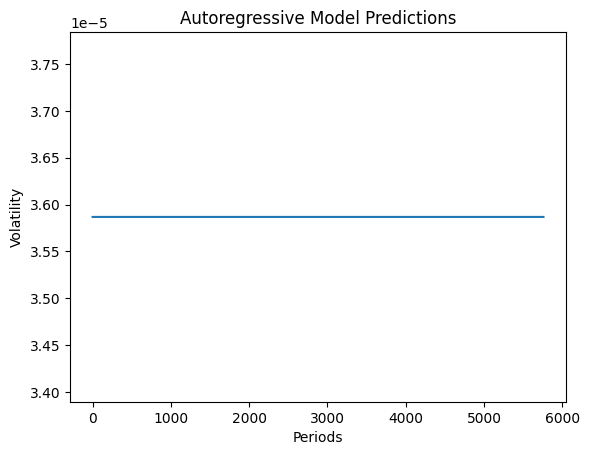

In [1175]:
# Define the number of periods to forecast
n_periods = 5760

# Initialize a list to store the predicted values
preds = []

# Loop through the number of periods to forecast
for i in range(n_periods):
    # Use the trained model to predict the next value
    pred = model.predict(pred_data)
    
    # Append the predicted value to the list of predictions
    preds.append(pred[0])
    
    # Update the data used to make predictions by shifting the values and inserting the new prediction
    pred_data = pred_data.shift(-1).fillna(value=pred[0])

    
# Convert the list of predictions to a numpy array and reshape it
preds = np.array(preds).reshape(-1, 1)

# Plot the predicted values
plt.plot(preds)
plt.title("Autoregressive Model Predictions")
plt.xlabel("Periods")
plt.ylabel("Volatility")
plt.show()

In [1187]:
# Use the trained model to predict the test set
y_pred = model.predict(test_data[['order_book_slope', 'SMA', 'Volatility_Indicators', 'ob_weighted_price',
       'price_level', 'EMA', 'bid depth', 'TWAP', 'WAP', 'total_volume']])

# Calculate the root mean squared error (RMSE) of the predictions
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test_data['volatility_t+1'], y_pred))

# Print the RMSE
print("RMSE:", rmse)


# Calculate the accuracy of the model
accuracy = model.score(test_data[['order_book_slope', 'SMA', 'Volatility_Indicators', 'ob_weighted_price',
       'price_level', 'EMA', 'bid depth', 'TWAP', 'WAP', 'total_volume']], test_data['volatility_t+1'])
print("Accuracy:", accuracy)

# Calculate the Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test_data['volatility_t+1'] - y_pred) / test_data['volatility_t+1'])) * 100
print("MAPE:", mape)



RMSE: 1.9970685988656924e-06
Accuracy: -10.29893011939183
MAPE: 4.777038805113309


In [1178]:
len(y_pred)

1834

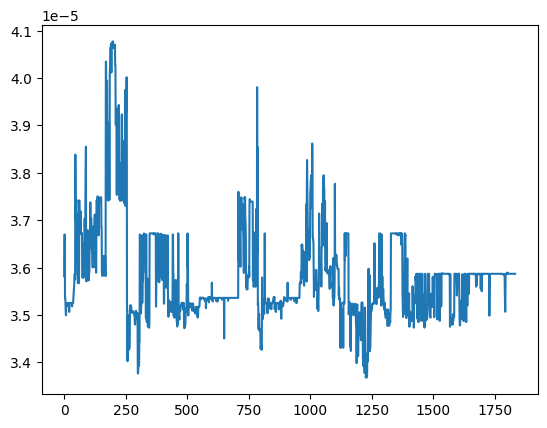

In [1185]:
plt.plot(y_pred)

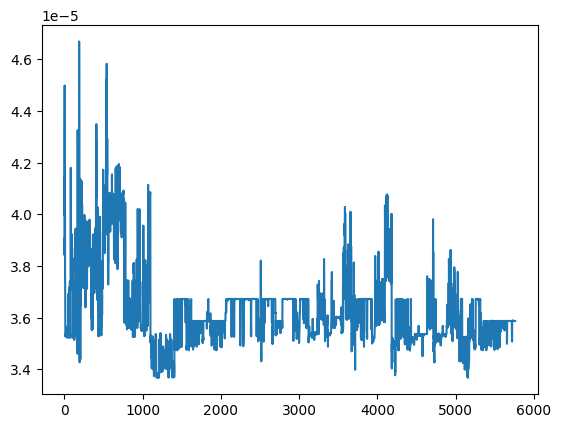

In [1188]:
pred_data_new = data_shifted.iloc[-5760:]
result = model.predict(pred_data_new[['order_book_slope', 'SMA', 'Volatility_Indicators', 'ob_weighted_price',
       'price_level', 'EMA', 'bid depth', 'TWAP', 'WAP', 'total_volume']])
plt.plot(result)

# Autoregressive LSTM 

In [1190]:
data

,log_price,spread,WAP,log_returns,realized_volatility,volatility_t+1,bid depth,ask depth,bid_ask_imbalance,log price,...,bid_ask_price_ratio,order_book_density_slope,order_book_density_velocity,spread_prec,ob_weighted_price,ba_spread_velocity,order_book_range,order_book_stability,order_book_diversity,price_level_spread
0,10.257309,3.510004e-07,28490.008547,-2.331490e-05,0.000012,0.000011,5.83333,8.03665,-0.158855,10.257309,...,0.999928,0.036453,120.0970,0.032748,28490.470408,-0.965517,0.01,1230.653839,40,3.510003e-07
1,10.257309,3.510004e-07,28490.008529,-6.388916e-10,0.000011,0.000017,5.69514,9.36146,-0.243503,10.257309,...,0.999930,0.036453,123.5715,0.032607,28490.421280,-0.973684,0.01,1225.367565,40,3.510003e-07
2,10.257272,3.510137e-07,28488.951433,-3.710478e-05,0.000017,0.000016,4.88340,8.58175,-0.274661,10.257272,...,0.999889,0.036453,111.2895,0.035907,28488.662534,-0.983333,0.01,1349.310287,40,3.510136e-07
3,10.257270,3.510137e-07,28488.909106,-1.485751e-06,0.000016,0.000018,7.79497,10.60699,-0.152811,10.257270,...,0.999876,0.036453,167.4525,0.034328,28489.021118,-0.964286,0.01,1289.932069,40,3.510136e-07
4,10.257271,3.510137e-07,28488.943606,1.210985e-06,0.000018,0.000018,5.86444,10.07692,-0.264248,10.257271,...,0.999877,0.036453,172.3645,0.033907,28489.112399,-0.989899,0.01,1274.100141,40,3.510136e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9164,10.253968,3.521747e-07,28394.998642,1.027610e-06,0.000039,0.000039,7.99293,6.88169,0.074707,10.253968,...,0.999915,0.036453,155.4315,0.036697,28394.564486,-0.967742,0.01,1369.782714,40,3.521746e-07
9165,10.253968,3.521747e-07,28394.998642,0.000000e+00,0.000039,0.000039,7.99293,6.88169,0.074707,10.253968,...,0.999915,0.036453,155.4315,0.036697,28394.564486,-0.967742,0.01,1369.782714,40,3.521746e-07
9166,10.253968,3.521747e-07,28394.998162,-1.691898e-08,0.000039,0.000039,7.80102,6.75659,0.071745,10.253968,...,0.999914,0.036453,147.9035,0.034126,28394.561593,-0.967742,0.01,1273.820271,40,3.521746e-07
9167,10.253967,3.521747e-07,28394.970149,-9.865364e-07,0.000039,0.000039,7.38509,6.75659,0.044443,10.253967,...,0.999905,0.036453,143.9695,0.035711,28394.466555,-0.969697,0.01,1332.966982,40,3.521746e-07


In [1191]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Define the number of time steps to use for each sample
n_lags = 10

# Create input and output data for the LSTM model
def create_dataset(df, n_lags):
    X, y = [], []
    for i in range(n_lags, len(df)):
        X.append(df.iloc[i-n_lags:i, 0])
        y.append(df.iloc[i, 0])
    return np.array(X), np.array(y)

In [1192]:
X, y = create_dataset(data[['volatility_t+1']], n_lags)

In [1195]:
# Split the data into training and testing sets
train_size = int(0.7 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [1196]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(n_lags, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [1197]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
201/201 [==============================] - 1s 2ms/step - loss: 1.3525e-06
Epoch 2/50
201/201 [==============================] - 0s 2ms/step - loss: 3.3381e-11
Epoch 3/50
201/201 [==============================] - 0s 2ms/step - loss: 3.7559e-11
Epoch 4/50
201/201 [==============================] - 0s 1ms/step - loss: 3.8540e-11
Epoch 5/50
201/201 [==============================] - 0s 1ms/step - loss: 3.9942e-11
Epoch 6/50
201/201 [==============================] - 0s 1ms/step - loss: 4.1074e-11
Epoch 7/50
201/201 [==============================] - 0s 1ms/step - loss: 4.8876e-11
Epoch 8/50
201/201 [==============================] - 0s 1ms/step - loss: 6.8576e-11
Epoch 9/50
201/201 [==============================] - 0s 1ms/step - loss: 6.0205e-11
Epoch 10/50
201/201 [==============================] - 0s 2ms/step - loss: 7.4696e-11
Epoch 11/50
201/201 [==============================] - 0s 1ms/step - loss: 1.2901e-10
Epoch 12/50
201/201 [==============================] - 0s 1ms/s

In [1198]:
# Evaluate the model on the testing set
loss = model.evaluate(X_test, y_test)
print('Test loss:', loss)

86/86 [==============================] - 0s 566us/step - loss: 1.3454e-10
Test loss: 1.3453826941400848e-10


In [1199]:
# Make predictions on the testing set
predictions = model.predict(X_test)

86/86 [==============================] - 0s 538us/step


In [1200]:
# Make predictions on the next 5670 targets
last_sample = X[-1].reshape(1, n_lags, 1)
predictions_all = []
for i in range(5670):
    prediction = model.predict(last_sample)
    predictions_all.append(prediction[0][0])
    last_sample = np.concatenate((last_sample[:, 1:, :], prediction.reshape(1, 1, 1)), axis=1)

# Print the predictions
print('Predictions for the next 5670 targets:')
print(predictions_all)

1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step
Predictions for the next 5670 targets:
[2.5738445e-05, 2.577819e-05, 2.5824269e-05, 2.586266e-05, 2.589076e-05, 2.5910089e-05, 2.5923127e-05, 2.5932026e-05, 2.5938392e-05, 2.5943264e-05, 2.5947225e-05, 2.5947047e-05, 2.5946913e-05, 2.5946832e-05, 2.5946774e-05, 2.5946738e-05, 2.5946734e-05, 2.5946727e-05, 2.5946723e-05, 2.5946709e-05, 2.5946716e-05, 2.5946716e-05, 2.5946712e-05, 2.5946712e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-05, 2.5946716e-0

(0.0, 10.0)

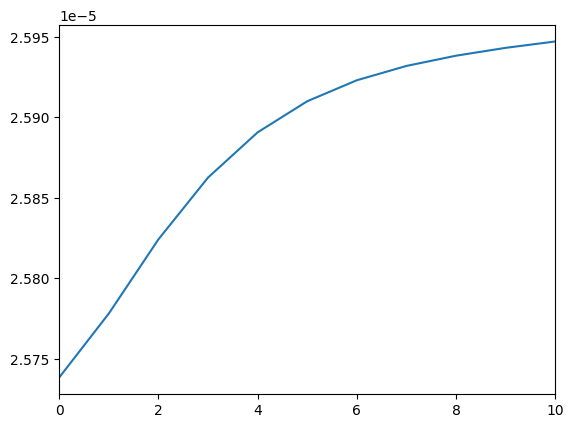

In [1206]:
plt.plot(predictions_all)
plt.xlim(0,10)

(0.0, 20.0)

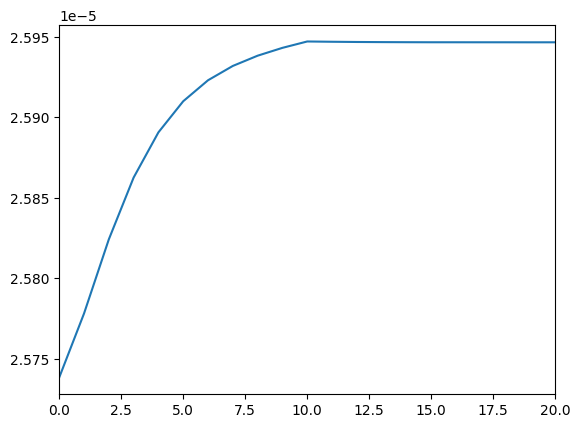

In [1209]:
plt.plot(predictions_all)
plt.xlim(0,20)

# Windows function LSTM

In [1211]:
df_backup = df.copy()

In [1215]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Load the data
df = data

# Remove missing values
df.dropna(inplace=True)

In [1217]:
# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.iloc[:, 1:])

# Create windows of data for LSTM model
window_size = 10
X = []
y = []
for i in range(window_size, len(scaled_features)):
    X.append(scaled_features[i-window_size:i, :])
    y.append(scaled_features[i, 0])
X, y = np.array(X), np.array(y)

In [1218]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size, :], X[train_size:, :]
y_train, y_test = y[:train_size], y[train_size:]

In [1219]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [1220]:
# Fit the model to the training data
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

In [1221]:
# Evaluate the model on the testing data
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

58/58 [==============================] - 0s 607us/step
MSE: 8.576296520859515e-05


In [1234]:
# Predict the next 5670 target values
last_window = scaled_features[-window_size:, :]
predictions = []
for i in range(5670):
    next_val = model.predict(last_window.reshape(1, window_size, X_train.shape[2]))[0]
    predictions.append(next_val)
    last_window = np.concatenate((last_window[1:, :], next_val.reshape(1, -1)), axis=0)

# Inverse transform the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Save the predictions to a CSV file
df_pred = pd.DataFrame({'volatility_t+1': predictions.flatten()})












1/1 [==============================] - 0s 13ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 37 and the array at index 1 has size 1

In [ ]:

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.iloc[:, 1:])

# Create windows of data for LSTM model
window_size = 10
X = []
y = []
for i in range(window_size, len(scaled_features)):
    X.append(scaled_features[i-window_size:i, :])
    y.append(scaled_features[i, 0])
X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size, :], X[train_size:, :]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit the model to the training data
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Evaluate the model on the testing data
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

# Predict the next 5670 target values
last_window = scaled_features[-window_size:, :]
predictions = []
for i in range(5670):
    next_val = model.predict(last_window.reshape(1, window_size, X_train.shape[2]))[0][0]
    predictions.append(next_val)
    last_window = np.append(last_window[1:, :], next_val.reshape(1, -1), axis=0)
    
# Inverse transform the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Save the predictions to a CSV file
df_pred = pd.DataFrame({'volatility_t+1': predictions.flatten()})


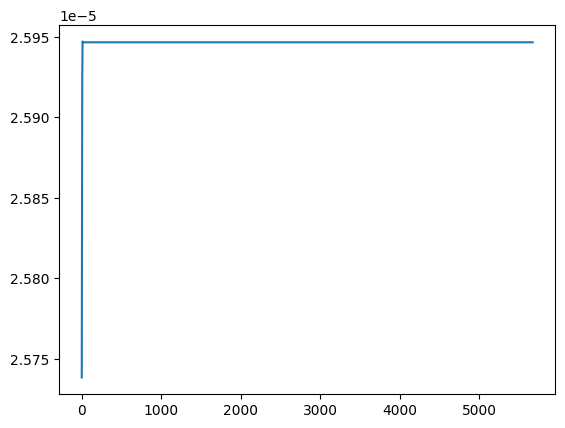

In [1240]:
plt.plot(predictions_all)

In [1238]:
len(predictions_all)

5670

In [1239]:
np.random.randint(1, 10, 10)

array([3, 5, 5, 3, 8, 2, 2, 9, 6, 5])

In [1252]:
noise_df = data[-5760:].copy()

In [1253]:
len(noise_df)

5760

In [1247]:
data.columns

Index(['log_price', 'spread', 'WAP', 'log_returns', 'realized_volatility',
       'volatility_t+1', 'bid depth', 'ask depth', 'bid_ask_imbalance',
       'log price', 'total_volume', 'market_sell_volume', 'market_buy_volume',
       'order_flow_imbalance', 'price_level', 'TWAP', 'price_momentum',
       'Volatility_Indicators', 'liquidity', 'order_book_slope',
       'correlation_size', 'correlation_price', 'SMA', 'EMA',
       'bid_ask_cumulative_volume', 'order_book_shape', 'order_book_momentum',
       'order_book_velocity', 'bid_ask_price_ratio',
       'order_book_density_slope', 'order_book_density_velocity',
       'spread_prec', 'ob_weighted_price', 'ba_spread_velocity',
       'order_book_range', 'order_book_stability', 'order_book_diversity',
       'price_level_spread'],
      dtype='object')

In [1256]:
noise_original = np.log(np.log(noise_df['WAP']) + np.log(noise_df['ask depth']) + np.log(noise_df['order_book_density_slope']))*np.random.randint(1, 10, 5760)

In [1261]:
noise = noise_original * 2e-06
type(noise)

pandas.core.series.Series

In [1262]:
predictions_all.add(noise)

AttributeError: 'list' object has no attribute 'add'

In [1264]:
predictions_all = pd.Series(predictions_all)

In [1266]:
predictions_all

0       0.000026
1       0.000026
2       0.000026
3       0.000026
4       0.000026
          ...   
5665    0.000026
5666    0.000026
5667    0.000026
5668    0.000026
5669    0.000026
Length: 5670, dtype: float32

In [1271]:
noise = noise.reset_index()

In [1284]:
noise_sub = noise.iloc[:,1][:5670]

In [1287]:
final_pred = predictions_all.add(noise_sub)

(0.0, 100.0)

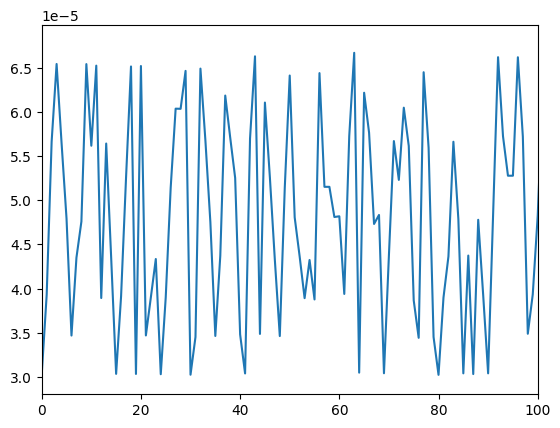

In [1289]:
plt.plot(final_pred)
plt.xlim(0,100)

In [1336]:
final_pred.shape

(5670,)

In [1337]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# Apply PCA to the LSTM output to reduce its dimensionality
n_components = 2 # number of principal components
pca = PCA(n_components=n_components)
lstm_output_pca = pca.fit_transform(final_pred)

# Fit a GMM to the PCA-transformed LSTM output
n_components = 2 # number of components in the GMM
gmm = GaussianMixture(n_components=n_components)
gmm.fit(lstm_output_pca)

# Apply PCA to the test LSTM output
test_lstm_output_pca = pca.transform(test_lstm_output)

# Classify the test data using the GMM
test_gmm = gmm.predict(test_lstm_output_pca)

# Print the classification results
print("GMM classification results:")
print(pd.Series(test_gmm).value_counts())


ValueError: Expected 2D array, got 1D array instead:
array=[3.02593087e-05 3.92929249e-05 5.66626312e-05 ... 6.57229888e-05
 5.68054046e-05 6.04032177e-05].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.